## ⚙️ Import Libraries

In [100]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from datetime import datetime

# Import necessary modules
import logging
import random
import numpy as np

from sklearn.utils.class_weight import compute_class_weight

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## ⏳ Load

In [101]:
# Load the dataset
data = np.load("/kaggle/input/mars-training/mars_for_students.npz")
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]
X_test = data["test_set"]

# Add a channel
X_train_val = X_train[..., np.newaxis]
y_train_val = y_train[..., np.newaxis]
X_test = X_test[..., np.newaxis] 

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train_val))

print(f"\nInput shape: {input_shape}")
print(f"Number of classes: {num_classes}")

print(f"\nShape of X_train: {X_train_val.shape}")
print(f"Shape of y_train: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")


Input shape: (64, 128)
Number of classes: 5

Shape of X_train: (2615, 64, 128, 1)
Shape of y_train: (2615, 64, 128, 1)
Shape of X_test: (10022, 64, 128, 1)


## 👽 Detect Outliers

In [102]:
# Define colormap
def apply_colormap(label, colormap):
    
    # Ensure label is 2D
    label = np.squeeze(label)

    # Ensure label values are in the valid range [0, num_classes-1]
    num_classes = len(colormap)  # Get the number of classes from the colormap
    label = np.clip(label, 0, num_classes - 1)  # Clip values to be within range

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

# Define the colormap (manually specifying colors for each class)
colormap = np.array([
    [0, 0, 0],        # black for background
    [139, 69, 19],    # brown for soil
    [80, 80, 80],  # gray for bedrock
    [244, 164, 96],   # sandy brown for sand
    [105, 105, 105]   # dark gray for big rock
]) / 255.0  # Normalize to [0, 1] range for matplotlib

# Function to calculate the hash of an image
def calculate_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Calculate hashes for each image and store their indices
def calculate_hash(y_train_val):
    hash_dict = defaultdict(list)
    for idx, image in enumerate(y_train_val):
        img_hash = calculate_image_hash(image)
        hash_dict[img_hash].append(idx)
    return hash_dict

# Find duplicates
def calculate_duplicates(y_train_val): 
    hash_dict = calculate_hash(y_train_val)
    return {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

# Plot duplicates
def plot_duplicates(y_train_val):
    duplicates = calculate_duplicates(y_train_val)

    if duplicates:
        print("Duplicate images found!")
   
        num_duplicates = len(duplicates)
        cols = 5 
        rows = (num_duplicates + cols - 1) // cols  
    
        # Create the figure and subplots
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        axes = axes.flatten()

        # Create colormap for labels
        num_classes = len(np.unique(y_train_val))
       
        for i, (img_hash, indices) in enumerate(duplicates.items()):
            # Select one representative image
            representative_idx = indices[0]
            occurrence_count = len(indices)  
            ax = axes[i]

            colored_label = apply_colormap(y_train_val[representative_idx], colormap)
            ax.imshow(colored_label)

            # Set title with hash, occurrences, and first index
            ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
            ax.axis('off')

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        
        plt.tight_layout()
        plt.show()

    else:
        print("No duplicate images found!")   

# Function to get images associated with a specific index
def get_images_by_index(index):
    hash_dict = calculate_hash(y_train_val)
    img_hash = calculate_image_hash(y_train_val[index])  # Calculate hash
    associated_indices = hash_dict.get(img_hash, [])  # Get duplicate indices
    return img_hash, associated_indices

# Function that prints a lot of small images
def get_lot_images_equals_to_index(index_of_interest, max_images_to_display=100):
    
    # Get images and duplicates
    img_hash, associated_indices = get_images_by_index(index_of_interest)

    if associated_indices:
        print(f"Hash for image at index {index_of_interest}: {img_hash}")
        
        # Limit the number of images to display
        num_images = min(len(associated_indices), max_images_to_display)
        print(f"Displaying {num_images} out of {len(associated_indices)} images.")
        
        cols = 5  # Number of columns in the grid
        rows = -(-num_images // cols)  # Ceiling division to get number of rows
        
        # Create colormap for labels
        num_classes = len(np.unique(y_train_val))
    
        # Smaller figure size for better compact visuals
        fig, axes = plt.subplots(rows, cols * 2, figsize=(cols * 3, rows * 3))
        axes = axes.reshape(rows, cols * 2)  # Ensure axes is 2D for easy access
    
        for i, idx in enumerate(associated_indices[:num_images]):
            row, col = divmod(i * 2, cols * 2)
            
            # Plot the image
            ax_image = axes[row, col]
            ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)
            ax_image.set_title(f"Image Idx: {idx}")
            ax_image.axis('off')
    
            # Plot the label
            ax_label = axes[row, col + 1]
            colored_label = apply_colormap(y_train_val[idx], colormap)
            ax_label.imshow(colored_label)
            ax_label.set_title("Label")
            ax_label.axis('off')
    
        # Hide unused axes
        for i in range(num_images * 2, rows * cols * 2):
            row, col = divmod(i, cols * 2)
            axes[row, col].axis('off')
    
        plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing
        plt.tight_layout()
        plt.show()
    
    else:
        print(f"No duplicates found for image at index {index_of_interest}.")

# Function that prints few images with a large size
def get_few_images_equals_to_index(index_of_interest):

    # Get images and duplicates
    img_hash, associated_indices = get_images_by_index(index_of_interest)

    if associated_indices:
        print(f"Hash for image at index {index_of_interest}: {img_hash}")
        
        num_images = len(associated_indices)
        cols = 2  # Show image and label side-by-side
        rows = num_images  # One row per image-label pair
        
        # Create colormap for labels
        num_classes = len(np.unique(y_train_val))
    
        # Larger figure size for better visuals
        fig, axes = plt.subplots(rows, cols, figsize=(20, 10 * rows))
        axes = axes.reshape(rows, cols)  # Ensure axes is 2D for easy access
    
        for i, idx in enumerate(associated_indices):
            # Plot the image
            ax_image = axes[i, 0]
            ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)
            ax_image.set_title(f"Image Idx: {idx}")
            ax_image.axis('off')
    
            # Plot the label
            ax_label = axes[i, 1]
            colored_label = apply_colormap(y_train_val[idx], colormap)
            ax_label.imshow(colored_label)
            ax_label.set_title("Label")
            ax_label.axis('off')
    
        plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing
        plt.tight_layout()
        plt.show()
    
    else:
        print(f"No duplicates found for image at index {index_of_interest}.")

Duplicate images found!


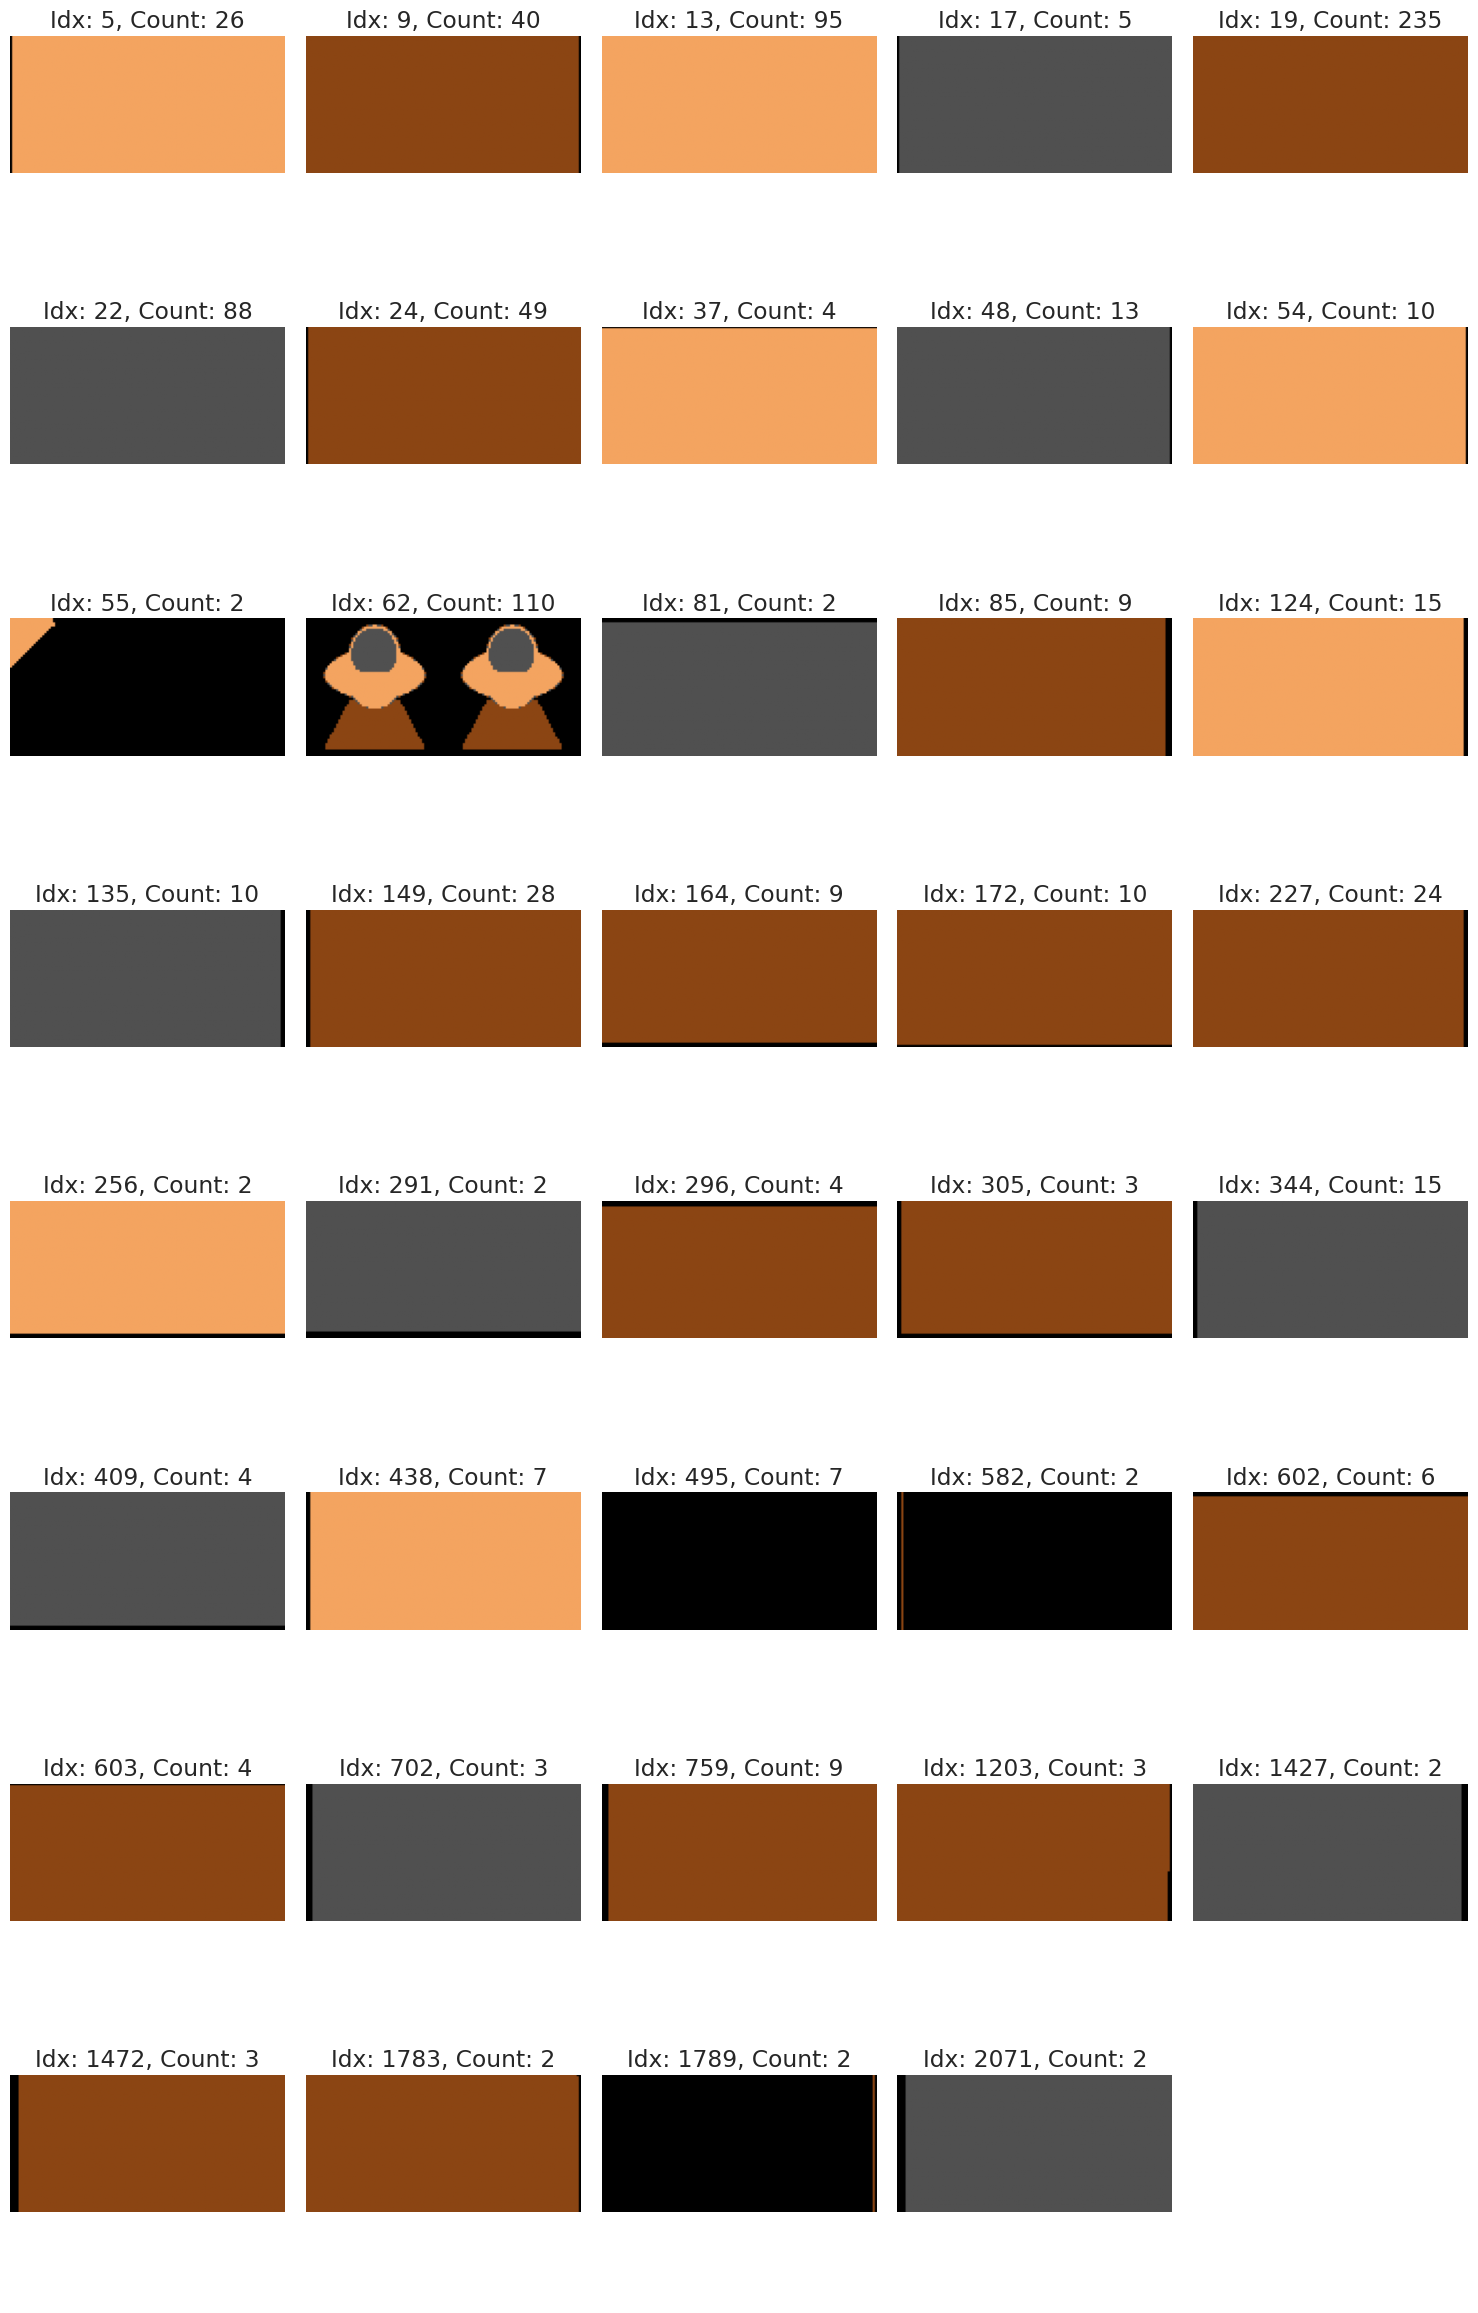

In [103]:
plot_duplicates(y_train_val)

In [104]:
alien_index = 62

# Get associated indices
img_hash, alin_associated_indices = get_images_by_index(alien_index)

if(X_train_val.shape[0] == 2615):
    X_train_val = np.delete(X_train_val, alin_associated_indices, axis=0)
    y_train_val = np.delete(y_train_val, alin_associated_indices, axis=0)
    print("Outliers removed")
else:
    print("Outliers already removed")

print("Dataset dimension:", X_train_val.shape)

Outliers removed
Dataset dimension: (2505, 64, 128, 1)


## 🔄 Process Data

In [105]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 0.2

In [106]:
# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)

# Display dataset information
print(f"Number of images:")
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")


Number of images:
Training set: 2004
Validation set: 501
Test set: 10022


In [107]:
# Define the category mapping
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4   # big rock
}

# Define the classes 
classes = ['background', 'soil', 'bedrock', 'sand', 'big rock'] 

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of categories: {len(category_map)}")

Number of categories: 5


In [108]:
# Define augmentation
def random_flip_left_right(image, label, seed):
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

def apply_augmentations(image, label):
    seed = np.random.randint(0, 1000000)
    image, label = random_flip_left_right(image, label, seed)
    return image, label

In [109]:
def preprocess_data(X, y, input_size=(64, 128)):
    X = tf.image.resize(X, input_size)
    X = tf.cast(X, tf.float32) / 255.0
    
    y = tf.image.resize(y, input_size, method='bilinear')
    y = tf.cast(y, tf.int32)
    return X, y

X_test = X_test / 255.0

In [110]:
def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a TensorFlow dataset. 
    """
    # Create dataset 
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) #create data from images and masks

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed) #we can shuffle it

    # Preprocess images and labels
    dataset = dataset.map(
        preprocess_data,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply augmentations 
    if augment:
        dataset = dataset.map(
            lambda x, y: apply_augmentations(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data 
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [111]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False 
)

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


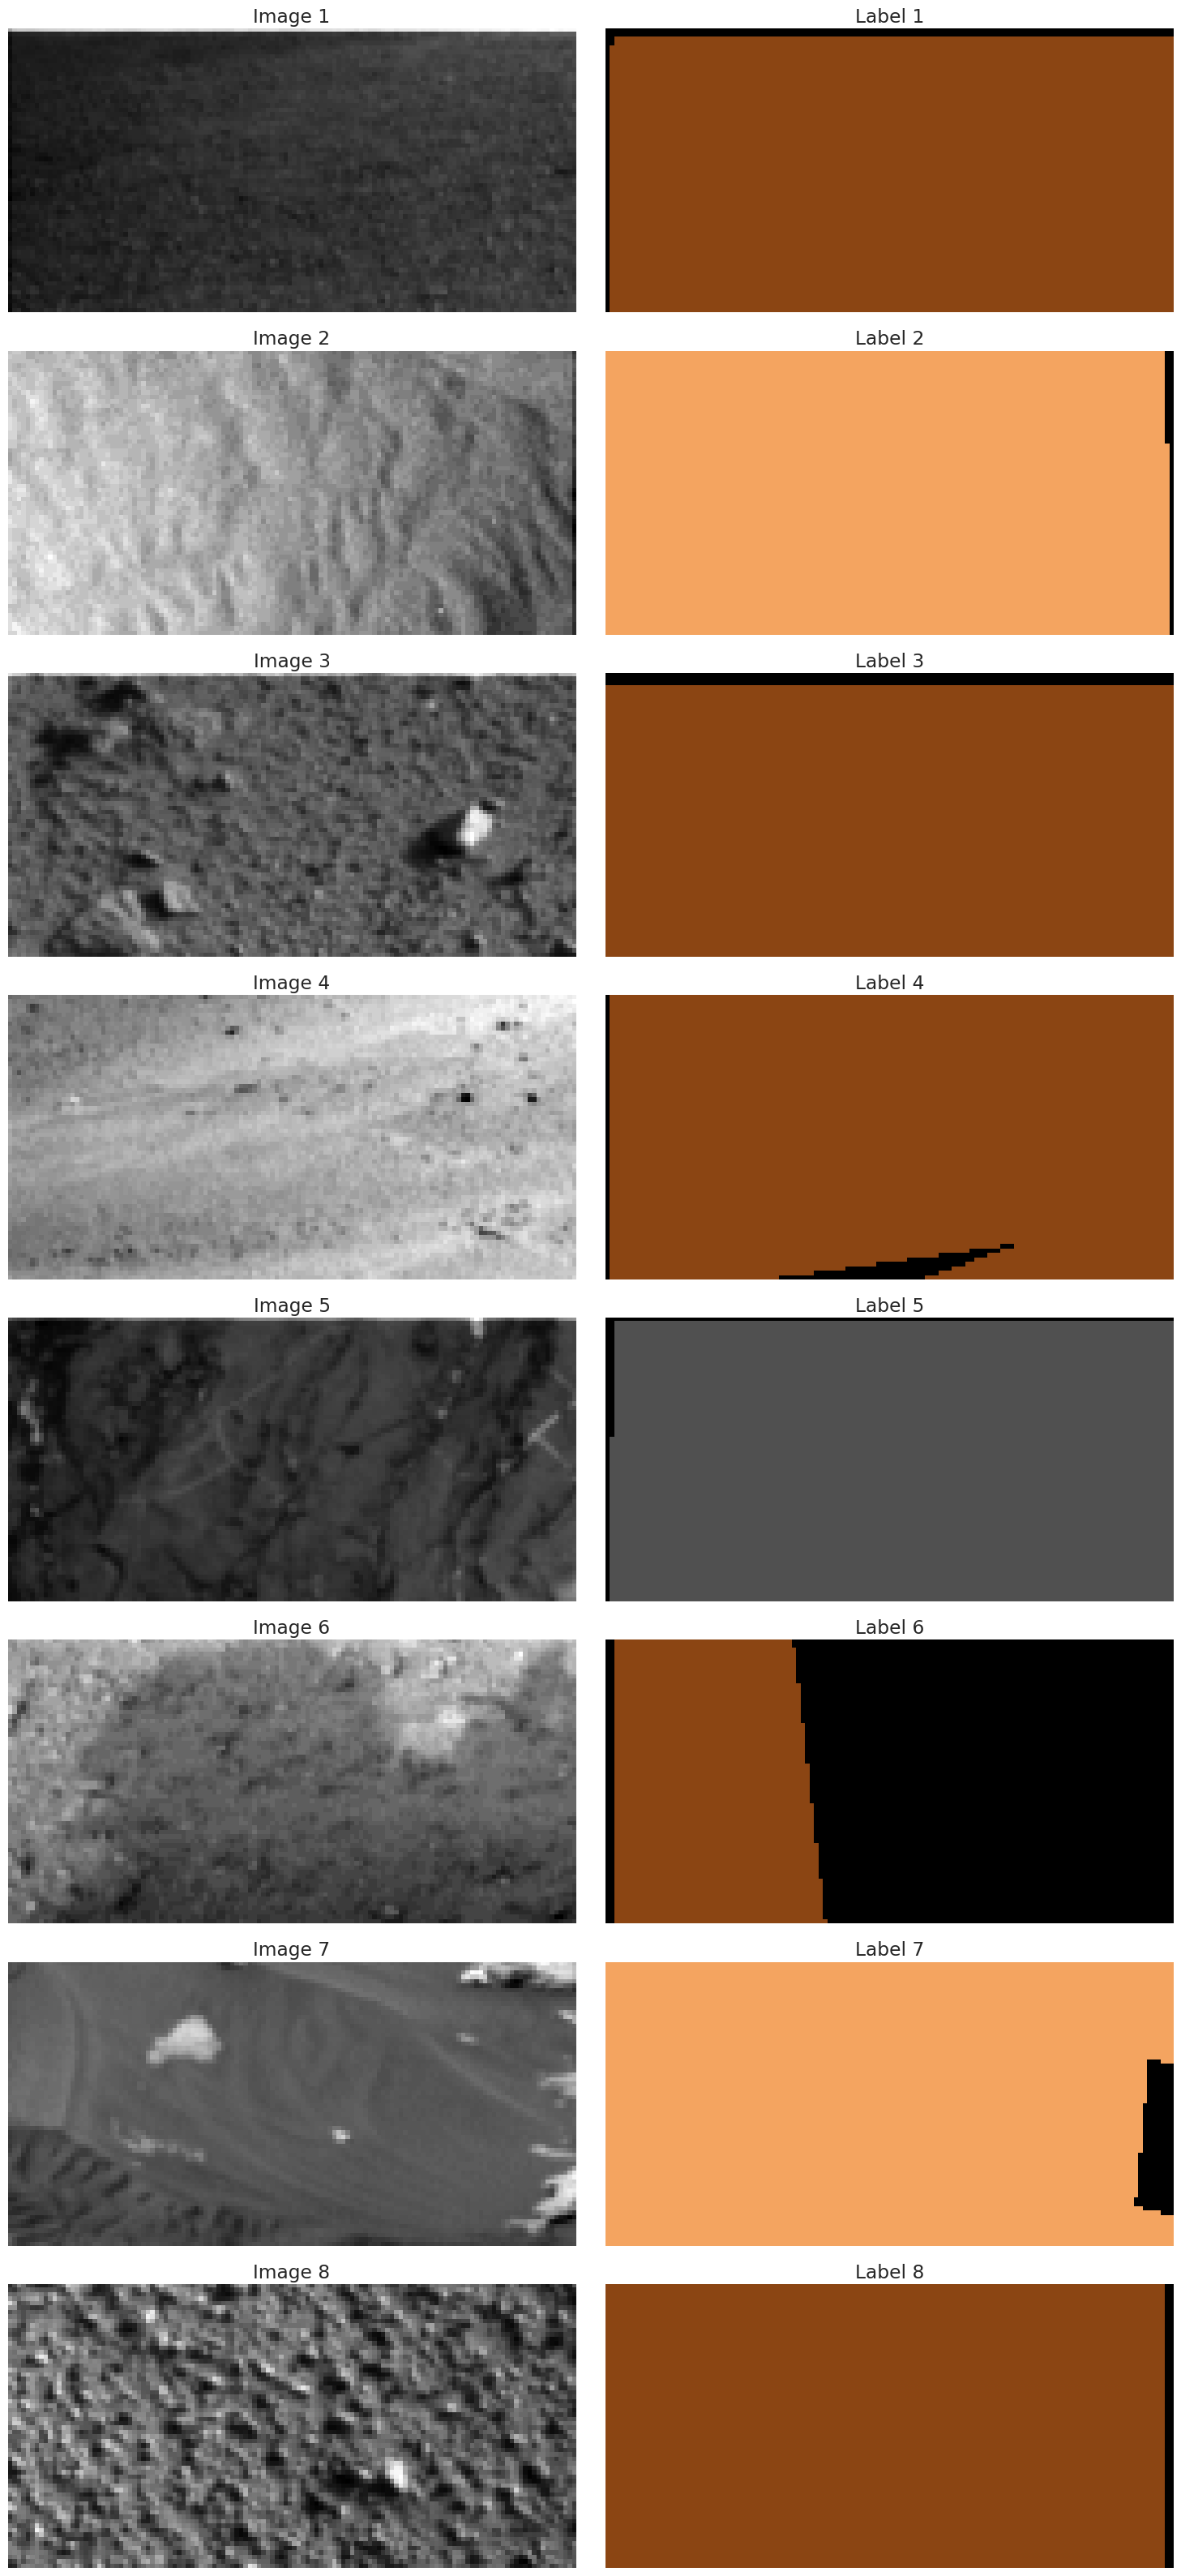

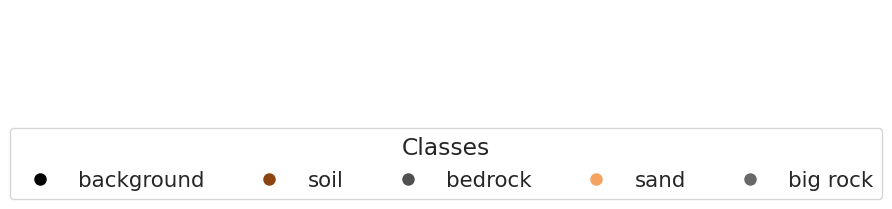

In [112]:
# Plot real image and ground truth (reduced resolution)
def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(category_map)  # Ensure colormap covers all classes, including the background
       # colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original grayscale image (no colormap)
            plt.subplot(num_samples, 2, j * 2 + 1)
            plt.imshow(images[j], cmap='gray')  # Use 'gray' cmap for the images (ensure grayscale)
            plt.title(f'Image {j + 1}')
            plt.axis('off')

            # Plot colored label (apply colormap only to labels)
            plt.subplot(num_samples, 2, j * 2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)  # Apply colormap to the labels only
            plt.imshow(colored_label)  # Show the colored label
            plt.title(f'Label {j + 1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

    handles = []
    
    # Legend
    for label_idx in category_map:
        color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))
    
    # Create a single legend displayed at the bottom
    fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
    ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
    ax.axis('off')
    plt.show()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=8)

## 🛠️ Model Definition and Training

In [113]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [114]:
# ASPP block
def aspp_block(input_tensor, num_classes, filters):
    # 1x1 Convolution branch
    conv_1x1 = tf.keras.layers.Conv2D(filters, kernel_size=1, padding="same", activation="relu")(input_tensor)

    # 3x3 Convolution with different dilation rates
    conv_3x3_6 = tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", dilation_rate=6, activation="relu")(input_tensor)
    conv_3x3_12 = tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", dilation_rate=12, activation="relu")(input_tensor)

    # Global Average Pooling branch
    gap = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)  # Reduces spatial dimensions
    gap = tf.keras.layers.Reshape((1, 1, -1))(gap)  # Reshape to match spatial dimensions for broadcasting
    gap = tf.keras.layers.Conv2D(filters, kernel_size=1, padding="same", activation="relu")(gap)  # 1x1 Conv
    gap = tf.keras.layers.UpSampling2D(size=(input_tensor.shape[1], input_tensor.shape[2]), interpolation='bilinear')(gap)

    # Concatenate all branches
    concat = tf.keras.layers.Concatenate()([conv_1x1, conv_3x3_6, conv_3x3_12, gap])
    
    # Output
    output = tf.keras.layers.Conv2D(num_classes, kernel_size=1, padding="same", activation="softmax")(concat)
    return output

In [115]:
# Transformer Block
@tf.keras.utils.register_keras_serializable()
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self,d_model=64, num_heads=8, num_transformer_blocks=4,input_shape=(4,8), dropout_rate=0.3):
        super().__init__()
        self.d_model = d_model
        self.in_channels = input_shape[2]
        self.num_transformer_blocks = num_transformer_blocks
        self.flatten = tfkl.Reshape((-1, d_model))
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.norm = tfkl.LayerNormalization()
        self.dense1 = tfkl.Dense(d_model*2, activation="relu")
        self.dense2 = tfkl.Dense(d_model, activation="relu")
        self.expand = tfkl.Reshape((input_shape[0], input_shape[1], self.d_model))
        self.match_channel = tfkl.Conv2D(input_shape[2], kernel_size=3, padding="same")
        self.add = tfkl.Add()
        self.dropout = tfkl.Dropout(dropout_rate)

    def call(self, x):
        if(self.in_channels != x.shape[3]):
            x = self.match_channel(x)
        x = self.flatten(x)
        for _ in range(self.num_transformer_blocks):
            skip = x
            x = self.att(x, x)
            x = self.dropout(x)
            x = self.norm(x)
            x = self.add([x,skip])
            x = self.norm(x)
            skip = x            
            #x = self.dense(x) # the classical uses a multilayer perceptron
            # First Dense layer
            x = self.dense1(x)
            x = self.dropout(x)
            # Second Dense layer (projection back to input dimension)
            x = self.dense2(x)
            x = self.dropout(x)            
            x = self.add([x,skip])
            x = self.norm(x)
        x = self.expand(x)
        #print("output",x.shape)
        return x

In [116]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')  # first block with 32 filters
    d1 = tfkl.MaxPooling2D()(down_block_1)  # reduce spatial complexity

    down_block_2 = unet_block(d1, 64, name='down_block2_')  # second block with 64 filters
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')  # third block with 128 filters
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, name='down_block4_')  # added block with 256 filters
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck with 512 filters
    transf = TransformerBlock(d_model=512, num_heads=8, num_transformer_blocks=4,input_shape=(4,8,512))
    bottleneck = transf(d4)
    bottleneck = aspp_block(bottleneck,num_classes, 512)

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)  # Upsampling layer

    u1 = tfkl.Concatenate()([u1, down_block_4, d3, tfkl.MaxPooling2D()(d2), tfkl.MaxPooling2D()(tfkl.MaxPooling2D()(d1))])  # Skip connection from downsampling path
    u1 = unet_block(u1, 256, name='up_block1_')  # first upsampling block with 256 filters

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_3, d2, tfkl.MaxPooling2D()(d1), tfkl.UpSampling2D()(down_block_4)])
    u2 = unet_block(u2, 128, name='up_block2_')  # second upsampling block with 128 filters

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2, d1, tfkl.UpSampling2D()(down_block_3), tfkl.UpSampling2D()(tfkl.UpSampling2D()(down_block_4))  ])
    u3 = unet_block(u3, 64, name='up_block3_')  # third upsampling block with 64 filters

    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1, tfkl.UpSampling2D()(down_block_2), tfkl.UpSampling2D()(tfkl.UpSampling2D()(down_block_3)), tfkl.UpSampling2D()(tfkl.UpSampling2D()(tfkl.UpSampling2D()(down_block_4)))])
    u4 = unet_block(u4, 32, name='up_block4_')  # fourth upsampling block with 32 filters

    # Output Layer: final convolution with softmax activation for segmentation
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_24  │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_25  │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_conv1 │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_bn1   │ (None, 16, 32,  │       512 │ down_block3_c… │   Y 

 Total params: 20,323,914 (77.53 MB)

 Trainable params: 20,320,074 (77.51 MB)

 Non-trainable params: 3,840 (15.00 KB)

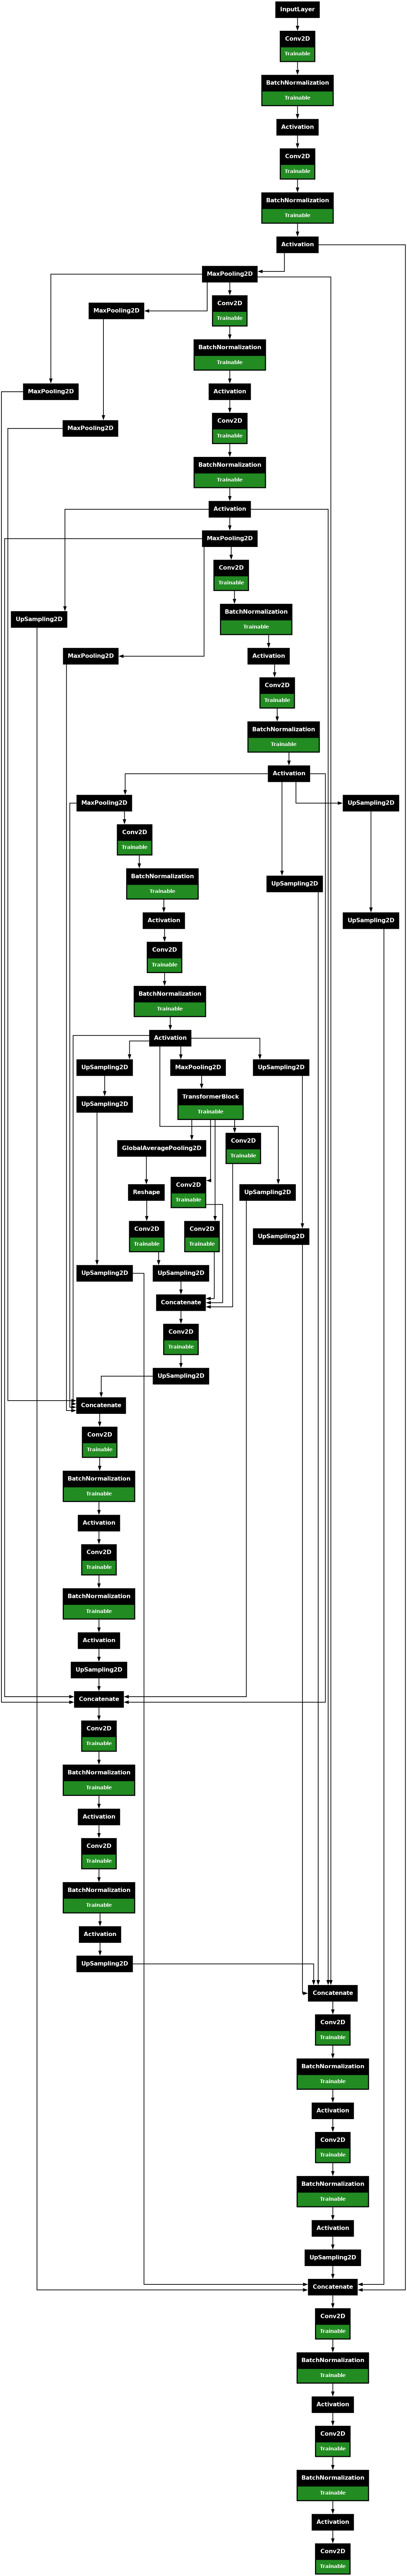

In [117]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=False, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=False, dpi=70)

In [119]:
# Define the metrics
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback: plot during the training the prediction and the images
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, frequency=5):
        super().__init__()
        self.val_dataset = val_dataset  # The validation dataset
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Get a batch from the validation dataset
            for image_batch, label_batch in self.val_dataset.take(1):
                image = image_batch[3]  # Take the first image from the batch
                label = label_batch[3]  # Take the first label from the batch

                # Add batch dimension to the image (if necessary)
                image = tf.expand_dims(image, 0)

                # Perform prediction
                pred = self.model.predict(image, verbose=0)
                y_pred = tf.math.argmax(pred, axis=-1)
                y_pred = y_pred.numpy()  # Convert to NumPy array for visualization

                # Create colormap (assuming a predefined function `create_segmentation_colormap`)
                num_classes = NUM_CLASSES
               # colormap = create_segmentation_colormap(num_classes)

                # Plot the results
                plt.figure(figsize=(16, 4))

                # Input image
                plt.subplot(1, 3, 1)
                plt.imshow(image[0], cmap='gray')
                plt.title("Input Image")
                plt.axis('off')

                # Ground truth
                plt.subplot(1, 3, 2)
                colored_label = apply_colormap(label.numpy(), colormap)  # Assuming `apply_colormap` is defined
                plt.imshow(colored_label)
                plt.title("Ground Truth Mask")
                plt.axis('off')

                # Prediction
                plt.subplot(1, 3, 3)
                colored_pred = apply_colormap(y_pred[0], colormap)  # Apply colormap to prediction
                plt.imshow(colored_pred)
                plt.title("Predicted Mask")
                plt.axis('off')

                plt.tight_layout()
                plt.show()
                plt.close()


In [120]:
# Flatten the labels to compute class weights
y_train_flat = y_train.flatten()

# Calculate weights
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train_flat), 
    y=y_train_flat
)

class_weights[0] = 0 # Exclude background
class_weights[4] = 10 # Reduce value for class 4
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

Class weights: {0: 0.0, 1: 0.5935027933021484, 2: 0.8366099618482732, 3: 1.1096943312319119, 4: 10.0}


In [121]:
# Define the loss
def sparse_weighted_loss(y_true, y_pred, class_weights):
    """
    Weighted sparse categorical cross-entropy.
    """
    # Convert y_true to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(class_weights))
    
    # Calculate weights for each sample
    weights = tf.reduce_sum(y_true_one_hot * tf.constant(class_weights, dtype=tf.float32), axis=-1)
    
    # Compute sparse categorical crossentropy loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    weights = tf.squeeze(weights, axis=-1)
    
    # Apply weights to the loss
    return tf.reduce_mean(loss * weights)

In [122]:
# Compile the model
model.compile(
    loss=lambda y_true, y_pred: sparse_weighted_loss(y_true, y_pred, class_weights),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

In [123]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=50,
    restore_best_weights=True
)

learning_rate = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=40, 
    min_delta=1e-5
)

viz_callback = VizCallback(val_dataset, frequency=5)

Epoch 1/1000


W0000 00:00:1734179081.366182      75 assert_op.cc:38] Ignoring Assert operator compile_loss/lambda/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.3610 - loss: 0.9035 - mean_iou: 0.1825

W0000 00:00:1734179127.740978      75 assert_op.cc:38] Ignoring Assert operator compile_loss/lambda/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3626 - loss: 0.8995 - mean_iou: 0.1839   

W0000 00:00:1734179160.029339      76 assert_op.cc:38] Ignoring Assert operator compile_loss/lambda/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734179167.303531      74 assert_op.cc:38] Ignoring Assert operator compile_loss/lambda/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


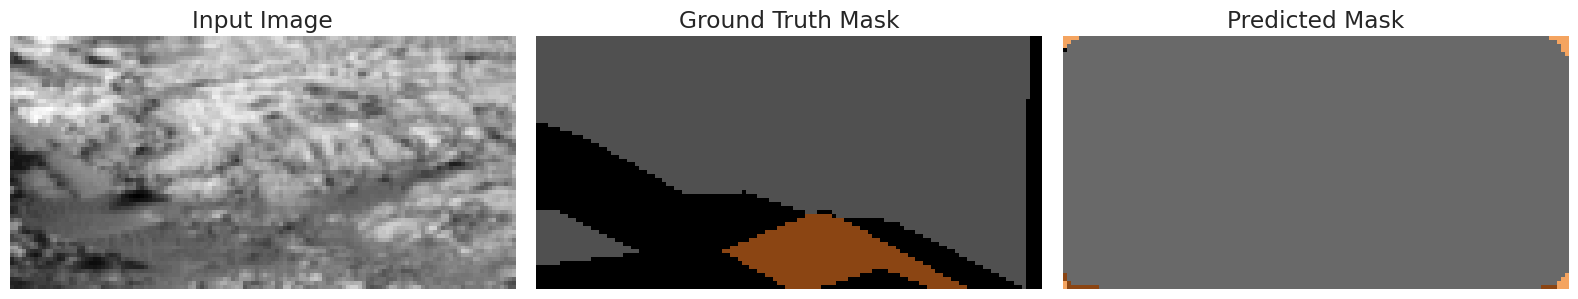

32/32 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.3641 - loss: 0.8957 - mean_iou: 0.1851 - val_accuracy: 0.0026 - val_loss: 18.5005 - val_mean_iou: 0.0013 - learning_rate: 0.0010
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 631ms/step - accuracy: 0.4811 - loss: 0.5636 - mean_iou: 0.2958 - val_accuracy: 0.0099 - val_loss: 12.7380 - val_mean_iou: 0.0057 - learning_rate: 0.0010
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 642ms/step - accuracy: 0.5413 - loss: 0.4588 - mean_iou: 0.3527 - val_accuracy: 0.0216 - val_loss: 14.1533 - val_mean_iou: 0.0095 - learning_rate: 0.0010
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 610ms/step - accuracy: 0.5415 - loss: 0.4300 - mean_iou: 0.3593 - val_accuracy: 0.0639 - val_loss: 4.2729 - val_mean_iou: 0.0417 - learning_rate: 0.0010
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 605ms/step - accuracy: 0.5641 - loss: 0.3869 - mean_iou: 0.4767 - val_accuracy: 0.1979 - val_loss: 2.5111 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 6/1000
32/32 ━━━━━━━━

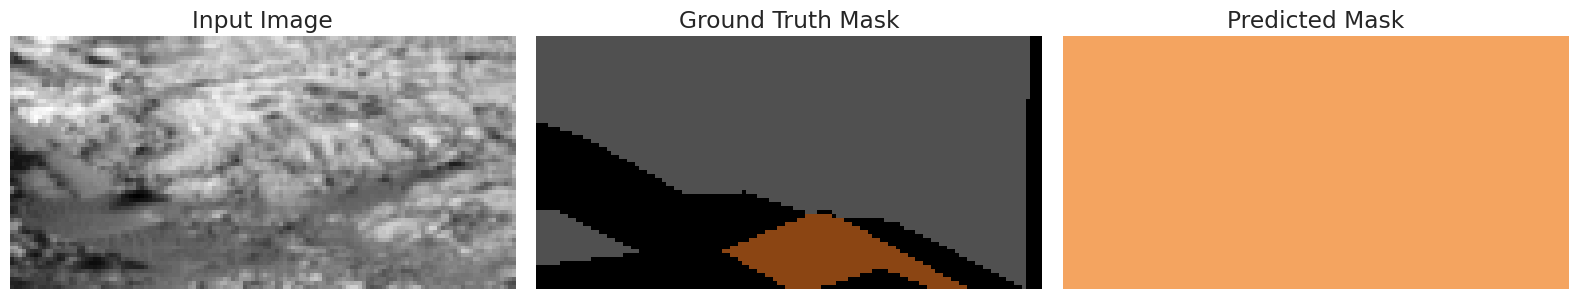

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 633ms/step - accuracy: 0.5635 - loss: 0.3981 - mean_iou: 0.4330 - val_accuracy: 0.1979 - val_loss: 3.0687 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 622ms/step - accuracy: 0.6004 - loss: 0.3358 - mean_iou: 0.5285 - val_accuracy: 0.1979 - val_loss: 2.5215 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.5964 - loss: 0.3398 - mean_iou: 0.5210 - val_accuracy: 0.1979 - val_loss: 2.7624 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 9/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 612ms/step - accuracy: 0.5881 - loss: 0.3478 - mean_iou: 0.5083 - val_accuracy: 0.1979 - val_loss: 2.9794 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 10/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 611ms/step - accuracy: 0.6124 - loss: 0.2984 - mean_iou: 0.5357 - val_accuracy: 0.1979 - val_loss: 2.7418 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 11/1000
32/32 ━━━━━━━

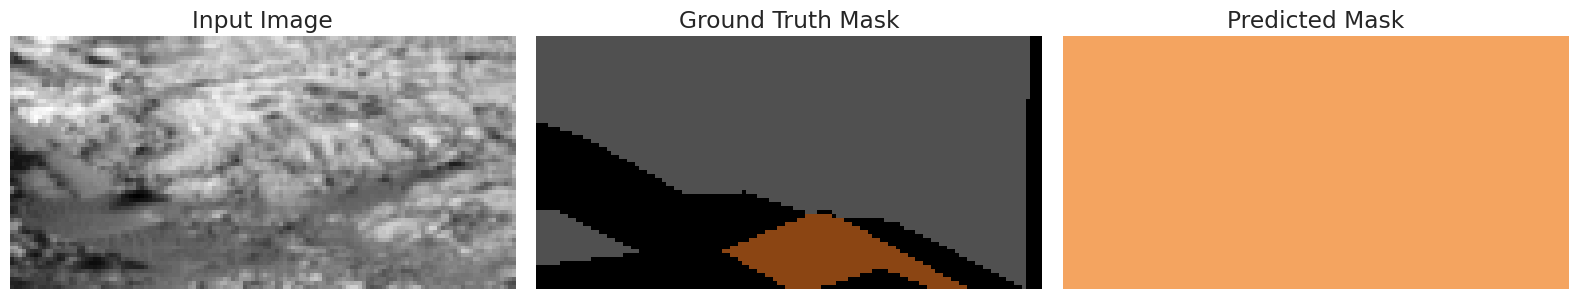

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - accuracy: 0.6053 - loss: 0.3093 - mean_iou: 0.5382 - val_accuracy: 0.1979 - val_loss: 2.0144 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 12/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.6290 - loss: 0.2697 - mean_iou: 0.5614 - val_accuracy: 0.2133 - val_loss: 1.7859 - val_mean_iou: 0.0781 - learning_rate: 0.0010
Epoch 13/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.6309 - loss: 0.2639 - mean_iou: 0.5690 - val_accuracy: 0.2199 - val_loss: 1.8042 - val_mean_iou: 0.0834 - learning_rate: 0.0010
Epoch 14/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.6338 - loss: 0.2516 - mean_iou: 0.5784 - val_accuracy: 0.2325 - val_loss: 2.1770 - val_mean_iou: 0.0940 - learning_rate: 0.0010
Epoch 15/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.6246 - loss: 0.2743 - mean_iou: 0.5662 - val_accuracy: 0.2510 - val_loss: 1.6888 - val_mean_iou: 0.1114 - learning_rate: 0.0010
Epoch 16/1000
32/32 ━━━━

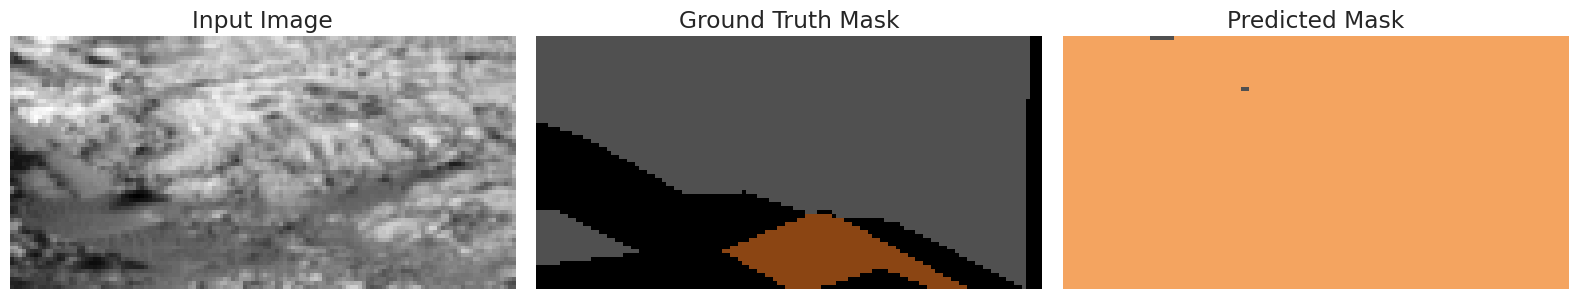

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.6277 - loss: 0.2610 - mean_iou: 0.5659 - val_accuracy: 0.2967 - val_loss: 1.3299 - val_mean_iou: 0.1541 - learning_rate: 0.0010
Epoch 17/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 613ms/step - accuracy: 0.6364 - loss: 0.2545 - mean_iou: 0.5843 - val_accuracy: 0.2778 - val_loss: 1.5339 - val_mean_iou: 0.1507 - learning_rate: 0.0010
Epoch 18/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.6492 - loss: 0.2271 - mean_iou: 0.6068 - val_accuracy: 0.2821 - val_loss: 1.3417 - val_mean_iou: 0.1552 - learning_rate: 0.0010
Epoch 19/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 620ms/step - accuracy: 0.6431 - loss: 0.2282 - mean_iou: 0.6029 - val_accuracy: 0.5683 - val_loss: 0.5197 - val_mean_iou: 0.4503 - learning_rate: 0.0010
Epoch 20/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.6406 - loss: 0.2292 - mean_iou: 0.5997 - val_accuracy: 0.4443 - val_loss: 0.7928 - val_mean_iou: 0.3113 - learning_rate: 0.0010
Epoch 21/1000
32/32 ━━━━

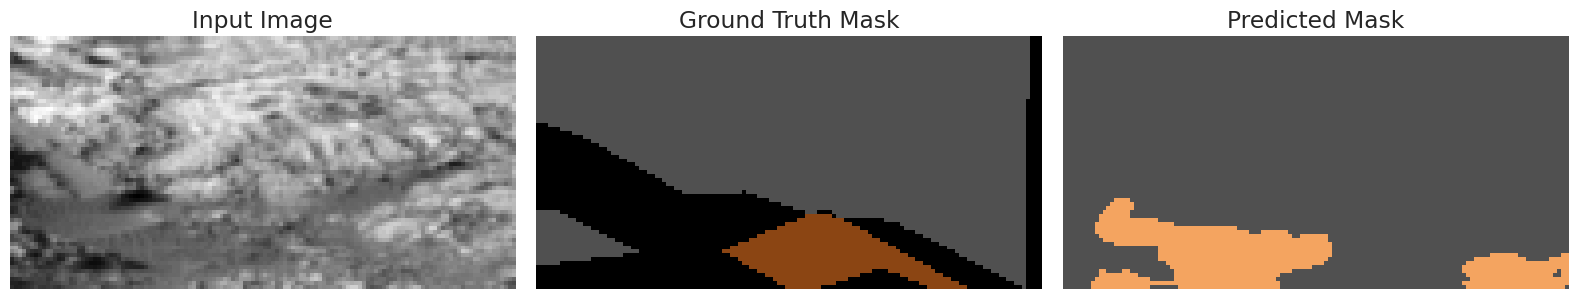

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - accuracy: 0.6472 - loss: 0.2310 - mean_iou: 0.5949 - val_accuracy: 0.4435 - val_loss: 0.6918 - val_mean_iou: 0.3116 - learning_rate: 0.0010
Epoch 22/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.6560 - loss: 0.2134 - mean_iou: 0.6071 - val_accuracy: 0.3654 - val_loss: 1.0981 - val_mean_iou: 0.2458 - learning_rate: 0.0010
Epoch 23/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.6635 - loss: 0.1904 - mean_iou: 0.6366 - val_accuracy: 0.4522 - val_loss: 0.7113 - val_mean_iou: 0.3261 - learning_rate: 0.0010
Epoch 24/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.6536 - loss: 0.1971 - mean_iou: 0.6314 - val_accuracy: 0.3711 - val_loss: 0.9866 - val_mean_iou: 0.2576 - learning_rate: 0.0010
Epoch 25/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.6591 - loss: 0.1867 - mean_iou: 0.6526 - val_accuracy: 0.3650 - val_loss: 1.2834 - val_mean_iou: 0.2406 - learning_rate: 0.0010
Epoch 26/1000
32/32 ━━━━

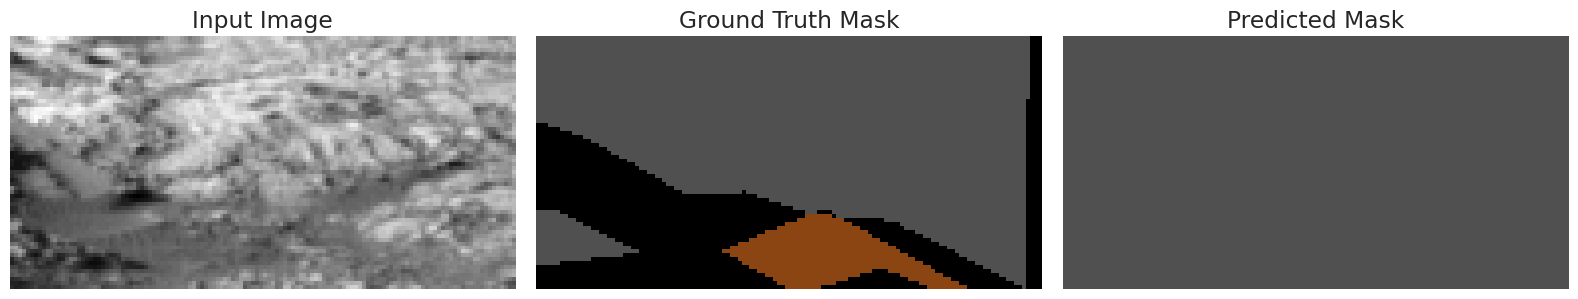

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - accuracy: 0.6652 - loss: 0.1835 - mean_iou: 0.6397 - val_accuracy: 0.4359 - val_loss: 0.6573 - val_mean_iou: 0.3339 - learning_rate: 0.0010
Epoch 27/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.6706 - loss: 0.1647 - mean_iou: 0.6778 - val_accuracy: 0.3466 - val_loss: 1.2778 - val_mean_iou: 0.2135 - learning_rate: 0.0010
Epoch 28/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.6647 - loss: 0.1814 - mean_iou: 0.6527 - val_accuracy: 0.6228 - val_loss: 0.2997 - val_mean_iou: 0.5502 - learning_rate: 0.0010
Epoch 29/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.6728 - loss: 0.1556 - mean_iou: 0.6926 - val_accuracy: 0.6051 - val_loss: 0.3499 - val_mean_iou: 0.5510 - learning_rate: 0.0010
Epoch 30/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.6691 - loss: 0.1668 - mean_iou: 0.6646 - val_accuracy: 0.5651 - val_loss: 0.5278 - val_mean_iou: 0.5001 - learning_rate: 0.0010
Epoch 31/1000
32/32 ━━━━

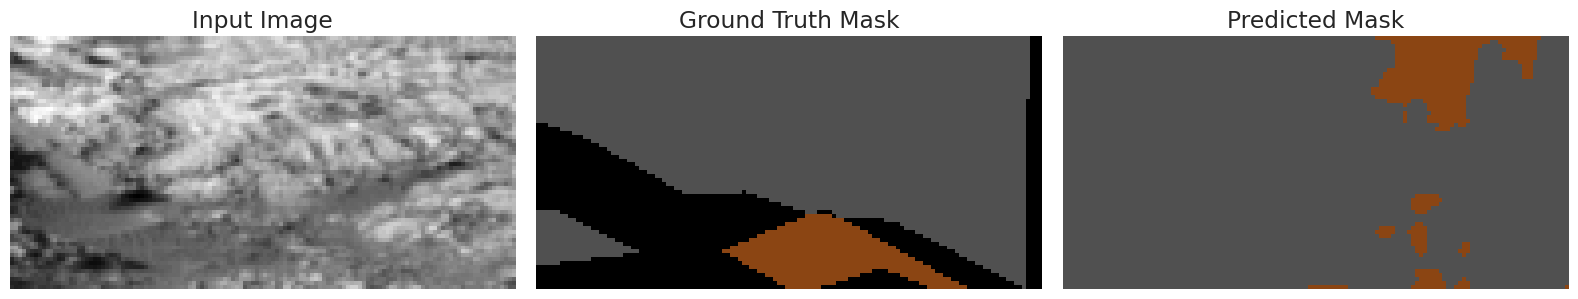

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - accuracy: 0.6773 - loss: 0.1509 - mean_iou: 0.7054 - val_accuracy: 0.6367 - val_loss: 0.3166 - val_mean_iou: 0.5496 - learning_rate: 0.0010
Epoch 32/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.6848 - loss: 0.1452 - mean_iou: 0.6808 - val_accuracy: 0.6748 - val_loss: 0.2288 - val_mean_iou: 0.6081 - learning_rate: 0.0010
Epoch 33/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.6797 - loss: 0.1493 - mean_iou: 0.6781 - val_accuracy: 0.6042 - val_loss: 0.3273 - val_mean_iou: 0.5586 - learning_rate: 0.0010
Epoch 34/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.6800 - loss: 0.1443 - mean_iou: 0.6933 - val_accuracy: 0.5641 - val_loss: 0.5131 - val_mean_iou: 0.4868 - learning_rate: 0.0010
Epoch 35/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.6729 - loss: 0.1660 - mean_iou: 0.6452 - val_accuracy: 0.5444 - val_loss: 0.5168 - val_mean_iou: 0.4557 - learning_rate: 0.0010
Epoch 36/1000
32/32 ━━━━

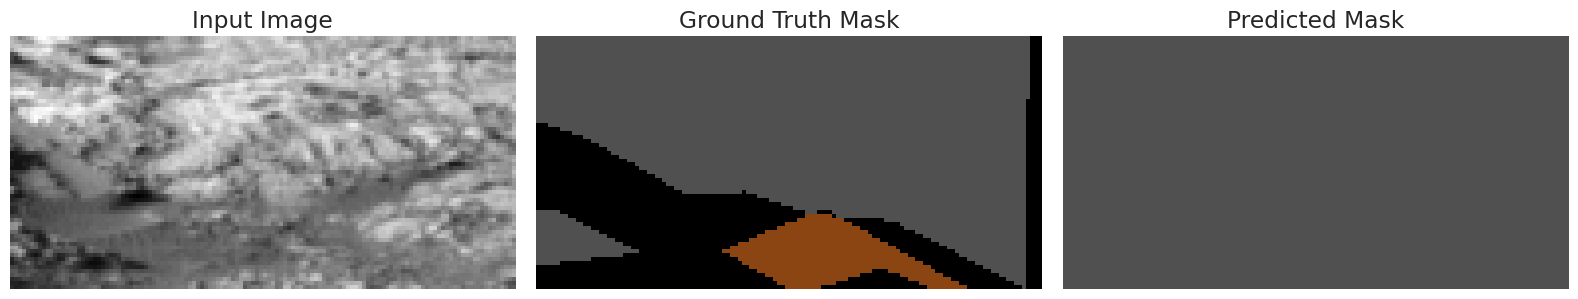

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.6834 - loss: 0.1424 - mean_iou: 0.7161 - val_accuracy: 0.5918 - val_loss: 0.3668 - val_mean_iou: 0.5186 - learning_rate: 0.0010
Epoch 37/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.6865 - loss: 0.1349 - mean_iou: 0.7222 - val_accuracy: 0.6584 - val_loss: 0.2428 - val_mean_iou: 0.6028 - learning_rate: 0.0010
Epoch 38/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.6876 - loss: 0.1249 - mean_iou: 0.7380 - val_accuracy: 0.6450 - val_loss: 0.2848 - val_mean_iou: 0.5997 - learning_rate: 0.0010
Epoch 39/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.6921 - loss: 0.1211 - mean_iou: 0.7568 - val_accuracy: 0.5657 - val_loss: 0.5146 - val_mean_iou: 0.4839 - learning_rate: 0.0010
Epoch 40/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 620ms/step - accuracy: 0.6845 - loss: 0.1244 - mean_iou: 0.7721 - val_accuracy: 0.6677 - val_loss: 0.2559 - val_mean_iou: 0.6416 - learning_rate: 0.0010
Epoch 41/1000
32/32 ━━━━

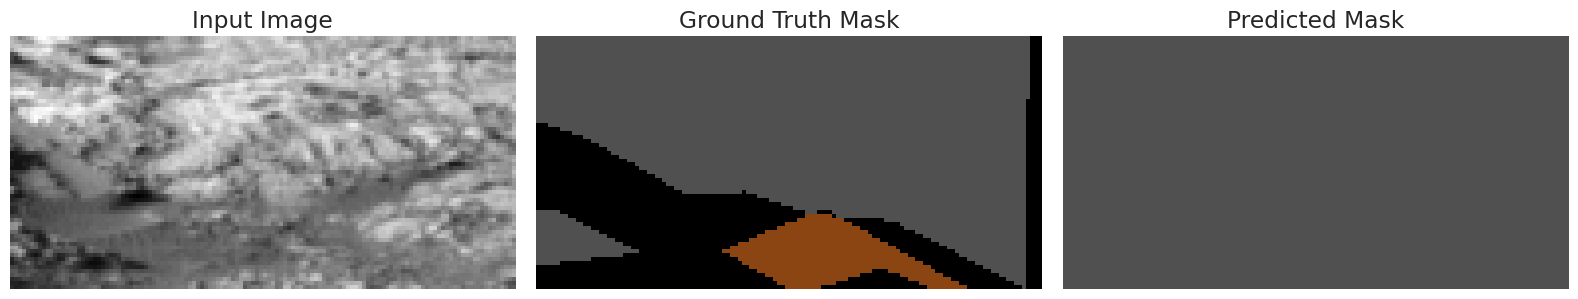

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 637ms/step - accuracy: 0.6940 - loss: 0.1112 - mean_iou: 0.7727 - val_accuracy: 0.6295 - val_loss: 0.2963 - val_mean_iou: 0.5811 - learning_rate: 0.0010
Epoch 42/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.6926 - loss: 0.1120 - mean_iou: 0.7630 - val_accuracy: 0.6141 - val_loss: 0.3727 - val_mean_iou: 0.5223 - learning_rate: 0.0010
Epoch 43/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.6953 - loss: 0.1103 - mean_iou: 0.7622 - val_accuracy: 0.5509 - val_loss: 0.4705 - val_mean_iou: 0.4525 - learning_rate: 0.0010
Epoch 44/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.6669 - loss: 0.1590 - mean_iou: 0.6702 - val_accuracy: 0.5171 - val_loss: 0.8657 - val_mean_iou: 0.4260 - learning_rate: 0.0010
Epoch 45/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.6942 - loss: 0.1268 - mean_iou: 0.7256 - val_accuracy: 0.3871 - val_loss: 1.3119 - val_mean_iou: 0.2858 - learning_rate: 0.0010
Epoch 46/1000
32/32 ━━━━

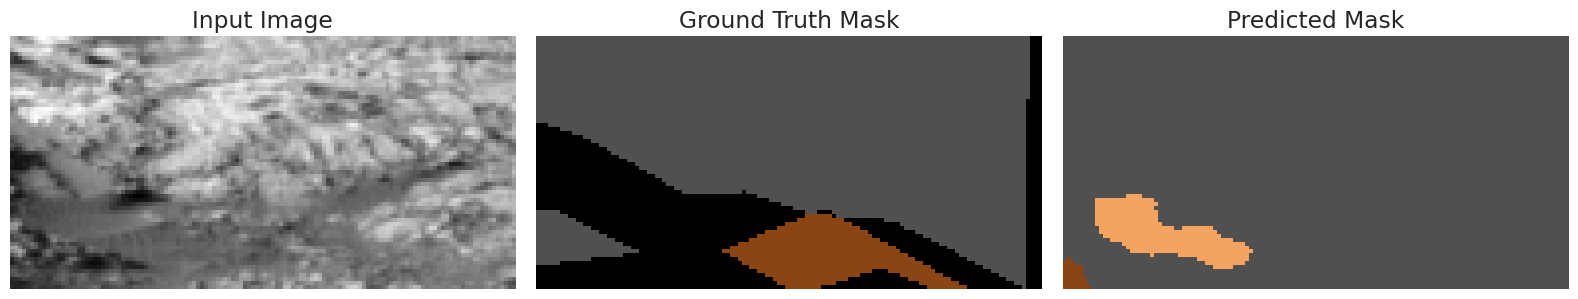

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.6919 - loss: 0.1171 - mean_iou: 0.7625 - val_accuracy: 0.4807 - val_loss: 0.7972 - val_mean_iou: 0.3918 - learning_rate: 0.0010
Epoch 47/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.6805 - loss: 0.1322 - mean_iou: 0.6952 - val_accuracy: 0.5258 - val_loss: 0.5137 - val_mean_iou: 0.4271 - learning_rate: 0.0010
Epoch 48/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.6928 - loss: 0.1155 - mean_iou: 0.7565 - val_accuracy: 0.6524 - val_loss: 0.2853 - val_mean_iou: 0.6254 - learning_rate: 0.0010
Epoch 49/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7047 - loss: 0.0954 - mean_iou: 0.7997 - val_accuracy: 0.6544 - val_loss: 0.2634 - val_mean_iou: 0.5874 - learning_rate: 0.0010
Epoch 50/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.6880 - loss: 0.1135 - mean_iou: 0.8155 - val_accuracy: 0.6464 - val_loss: 0.3126 - val_mean_iou: 0.5637 - learning_rate: 0.0010
Epoch 51/1000
32/32 ━━━━

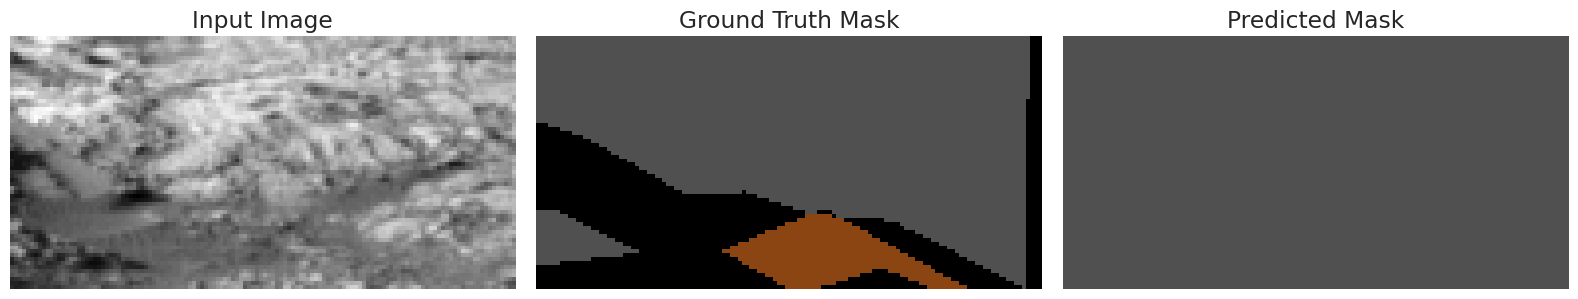

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 638ms/step - accuracy: 0.7069 - loss: 0.0848 - mean_iou: 0.8310 - val_accuracy: 0.6091 - val_loss: 0.3998 - val_mean_iou: 0.5566 - learning_rate: 0.0010
Epoch 52/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7032 - loss: 0.0894 - mean_iou: 0.7941 - val_accuracy: 0.6489 - val_loss: 0.2808 - val_mean_iou: 0.5993 - learning_rate: 0.0010
Epoch 53/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7123 - loss: 0.0814 - mean_iou: 0.8292 - val_accuracy: 0.6388 - val_loss: 0.2754 - val_mean_iou: 0.5788 - learning_rate: 0.0010
Epoch 54/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7123 - loss: 0.0748 - mean_iou: 0.8627 - val_accuracy: 0.6557 - val_loss: 0.2577 - val_mean_iou: 0.6277 - learning_rate: 0.0010
Epoch 55/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.7111 - loss: 0.0750 - mean_iou: 0.8455 - val_accuracy: 0.5386 - val_loss: 0.4749 - val_mean_iou: 0.5257 - learning_rate: 0.0010
Epoch 56/1000
32/32 ━━━━

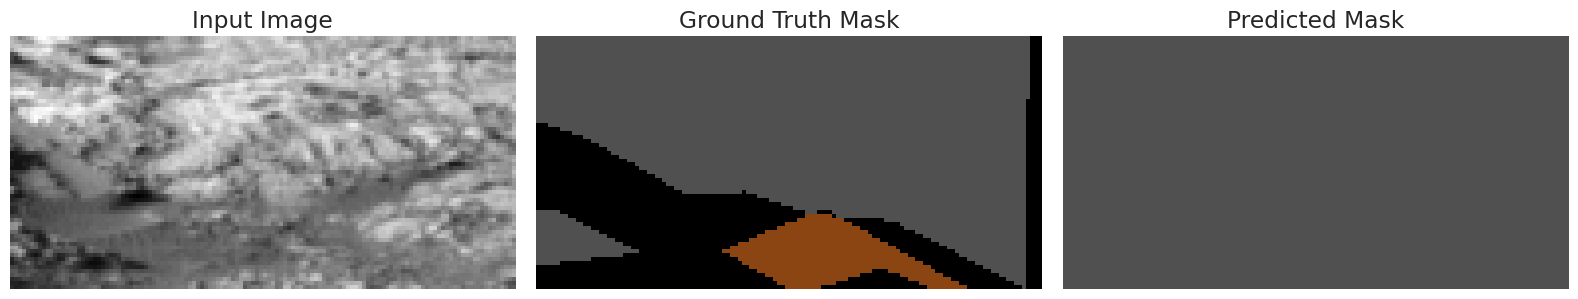

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 632ms/step - accuracy: 0.7151 - loss: 0.0666 - mean_iou: 0.8537 - val_accuracy: 0.6597 - val_loss: 0.2886 - val_mean_iou: 0.6248 - learning_rate: 0.0010
Epoch 57/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - accuracy: 0.7184 - loss: 0.0591 - mean_iou: 0.8721 - val_accuracy: 0.5505 - val_loss: 0.4684 - val_mean_iou: 0.4832 - learning_rate: 0.0010
Epoch 58/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7123 - loss: 0.0717 - mean_iou: 0.8746 - val_accuracy: 0.6432 - val_loss: 0.2588 - val_mean_iou: 0.6072 - learning_rate: 0.0010
Epoch 59/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7175 - loss: 0.0725 - mean_iou: 0.8694 - val_accuracy: 0.5849 - val_loss: 0.4128 - val_mean_iou: 0.5033 - learning_rate: 0.0010
Epoch 60/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.7070 - loss: 0.0844 - mean_iou: 0.8471 - val_accuracy: 0.5360 - val_loss: 0.6526 - val_mean_iou: 0.4363 - learning_rate: 0.0010
Epoch 61/1000
32/32 ━━━━

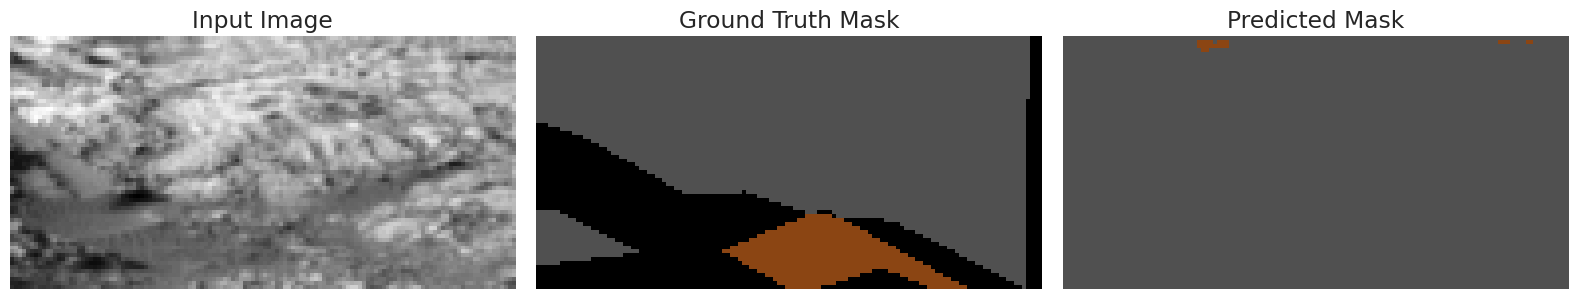

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 638ms/step - accuracy: 0.7082 - loss: 0.0744 - mean_iou: 0.8686 - val_accuracy: 0.6071 - val_loss: 0.3982 - val_mean_iou: 0.5382 - learning_rate: 0.0010
Epoch 62/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.6914 - loss: 0.1217 - mean_iou: 0.7294 - val_accuracy: 0.5835 - val_loss: 0.5286 - val_mean_iou: 0.4861 - learning_rate: 0.0010
Epoch 63/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - accuracy: 0.7015 - loss: 0.1201 - mean_iou: 0.6894 - val_accuracy: 0.6325 - val_loss: 0.3093 - val_mean_iou: 0.5723 - learning_rate: 0.0010
Epoch 64/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - accuracy: 0.7136 - loss: 0.0776 - mean_iou: 0.7608 - val_accuracy: 0.5890 - val_loss: 0.4267 - val_mean_iou: 0.5156 - learning_rate: 0.0010
Epoch 65/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - accuracy: 0.7133 - loss: 0.0745 - mean_iou: 0.8176 - val_accuracy: 0.6261 - val_loss: 0.3373 - val_mean_iou: 0.6110 - learning_rate: 0.0010
Epoch 66/1000
32/32 ━━━━

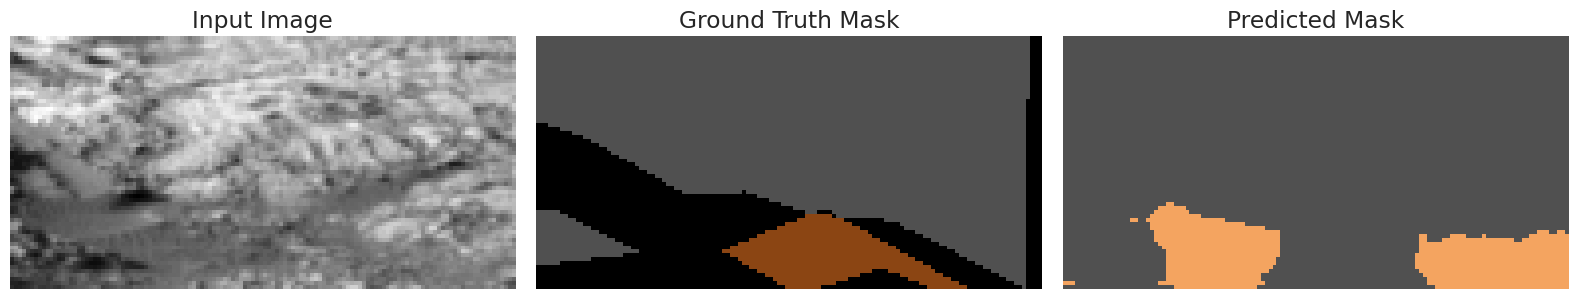

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 633ms/step - accuracy: 0.7184 - loss: 0.0609 - mean_iou: 0.8777 - val_accuracy: 0.5957 - val_loss: 0.4271 - val_mean_iou: 0.5005 - learning_rate: 0.0010
Epoch 67/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - accuracy: 0.7154 - loss: 0.0674 - mean_iou: 0.8547 - val_accuracy: 0.6468 - val_loss: 0.3251 - val_mean_iou: 0.5978 - learning_rate: 0.0010
Epoch 68/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - accuracy: 0.7249 - loss: 0.0487 - mean_iou: 0.8964 - val_accuracy: 0.6575 - val_loss: 0.2718 - val_mean_iou: 0.6285 - learning_rate: 0.0010
Epoch 69/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.7279 - loss: 0.0412 - mean_iou: 0.8953 - val_accuracy: 0.6009 - val_loss: 0.4149 - val_mean_iou: 0.5285 - learning_rate: 0.0010
Epoch 70/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7218 - loss: 0.0546 - mean_iou: 0.8914 - val_accuracy: 0.5706 - val_loss: 0.5825 - val_mean_iou: 0.4608 - learning_rate: 0.0010
Epoch 71/1000
32/32 ━━━━

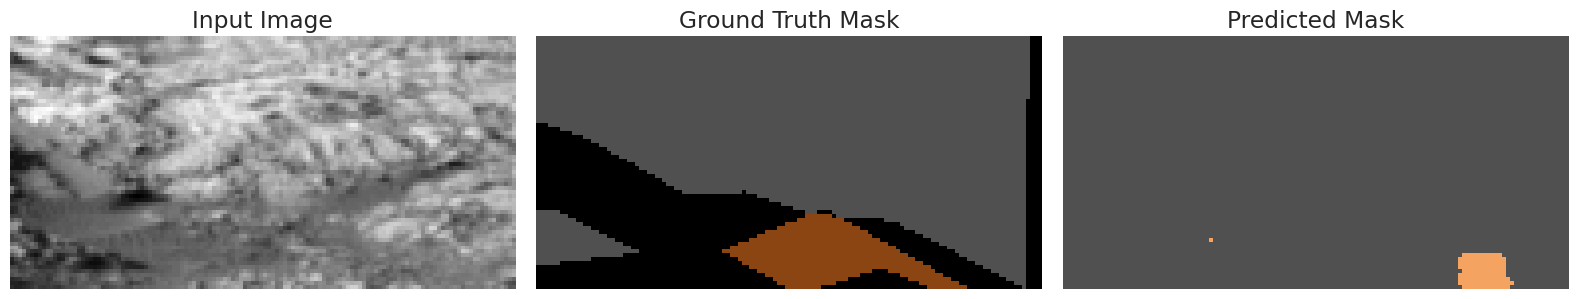

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 638ms/step - accuracy: 0.7230 - loss: 0.0503 - mean_iou: 0.9004 - val_accuracy: 0.6571 - val_loss: 0.2782 - val_mean_iou: 0.6209 - learning_rate: 0.0010
Epoch 72/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7226 - loss: 0.0540 - mean_iou: 0.8965 - val_accuracy: 0.6300 - val_loss: 0.3700 - val_mean_iou: 0.5892 - learning_rate: 0.0010
Epoch 73/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 621ms/step - accuracy: 0.7267 - loss: 0.0421 - mean_iou: 0.9194 - val_accuracy: 0.6701 - val_loss: 0.2377 - val_mean_iou: 0.6564 - learning_rate: 1.0000e-04
Epoch 74/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 621ms/step - accuracy: 0.7321 - loss: 0.0315 - mean_iou: 0.9378 - val_accuracy: 0.6853 - val_loss: 0.2084 - val_mean_iou: 0.6733 - learning_rate: 1.0000e-04
Epoch 75/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 620ms/step - accuracy: 0.7332 - loss: 0.0286 - mean_iou: 0.9405 - val_accuracy: 0.6891 - val_loss: 0.2033 - val_mean_iou: 0.6848 - learning_rate: 1.0000e-04
Epoch 76/100

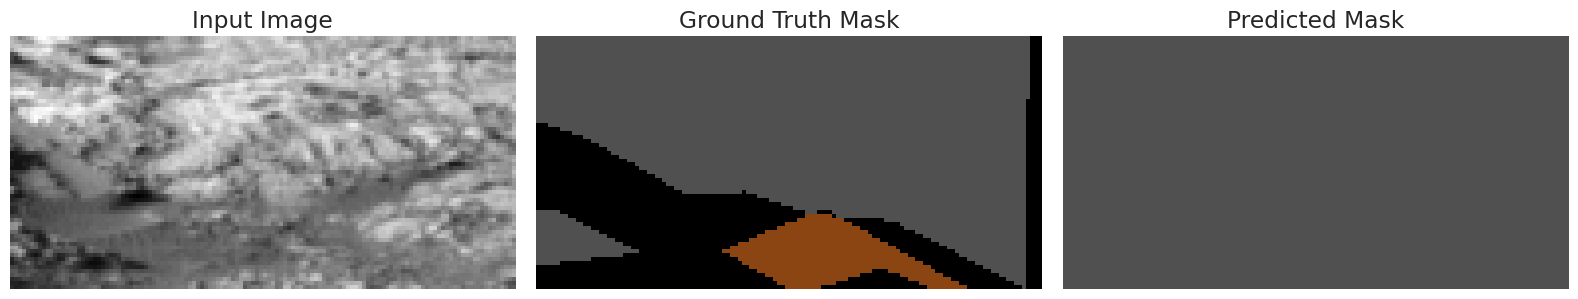

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - accuracy: 0.7316 - loss: 0.0283 - mean_iou: 0.9336 - val_accuracy: 0.6900 - val_loss: 0.2004 - val_mean_iou: 0.6853 - learning_rate: 1.0000e-04
Epoch 77/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.7315 - loss: 0.0254 - mean_iou: 0.9532 - val_accuracy: 0.6902 - val_loss: 0.2014 - val_mean_iou: 0.6862 - learning_rate: 1.0000e-04
Epoch 78/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.7380 - loss: 0.0253 - mean_iou: 0.9519 - val_accuracy: 0.6929 - val_loss: 0.2056 - val_mean_iou: 0.6905 - learning_rate: 1.0000e-04
Epoch 79/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 620ms/step - accuracy: 0.7370 - loss: 0.0254 - mean_iou: 0.9541 - val_accuracy: 0.6928 - val_loss: 0.2040 - val_mean_iou: 0.6911 - learning_rate: 1.0000e-04
Epoch 80/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7341 - loss: 0.0253 - mean_iou: 0.9379 - val_accuracy: 0.6924 - val_loss: 0.2062 - val_mean_iou: 0.6899 - learning_rate: 1.0000e-04
Epoc

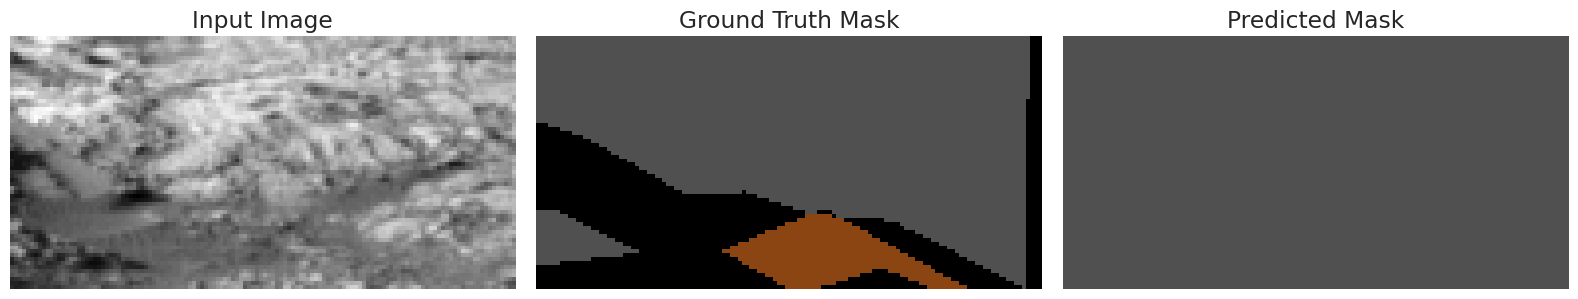

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - accuracy: 0.7350 - loss: 0.0226 - mean_iou: 0.9526 - val_accuracy: 0.6925 - val_loss: 0.2101 - val_mean_iou: 0.6915 - learning_rate: 1.0000e-04
Epoch 82/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7369 - loss: 0.0227 - mean_iou: 0.9529 - val_accuracy: 0.6907 - val_loss: 0.2128 - val_mean_iou: 0.6868 - learning_rate: 1.0000e-04
Epoch 83/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.7345 - loss: 0.0238 - mean_iou: 0.9503 - val_accuracy: 0.6918 - val_loss: 0.2104 - val_mean_iou: 0.6928 - learning_rate: 1.0000e-04
Epoch 84/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7378 - loss: 0.0215 - mean_iou: 0.9666 - val_accuracy: 0.6914 - val_loss: 0.2069 - val_mean_iou: 0.6921 - learning_rate: 1.0000e-04
Epoch 85/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7370 - loss: 0.0212 - mean_iou: 0.9627 - val_accuracy: 0.6922 - val_loss: 0.2102 - val_mean_iou: 0.6922 - learning_rate: 1.0000e-04
Epoc

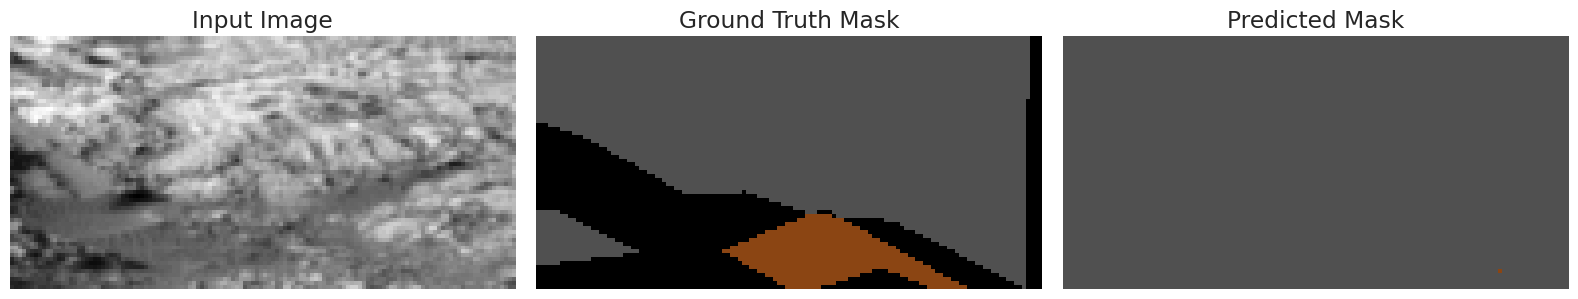

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - accuracy: 0.7361 - loss: 0.0209 - mean_iou: 0.9521 - val_accuracy: 0.6923 - val_loss: 0.2099 - val_mean_iou: 0.6939 - learning_rate: 1.0000e-04
Epoch 87/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7384 - loss: 0.0227 - mean_iou: 0.9529 - val_accuracy: 0.6927 - val_loss: 0.2157 - val_mean_iou: 0.6930 - learning_rate: 1.0000e-04
Epoch 88/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7366 - loss: 0.0201 - mean_iou: 0.9581 - val_accuracy: 0.6930 - val_loss: 0.2205 - val_mean_iou: 0.6920 - learning_rate: 1.0000e-04
Epoch 89/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7343 - loss: 0.0203 - mean_iou: 0.9575 - val_accuracy: 0.6913 - val_loss: 0.2260 - val_mean_iou: 0.6889 - learning_rate: 1.0000e-04
Epoch 90/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7349 - loss: 0.0185 - mean_iou: 0.9664 - val_accuracy: 0.6925 - val_loss: 0.2263 - val_mean_iou: 0.6920 - learning_rate: 1.0000e-04
Epoc

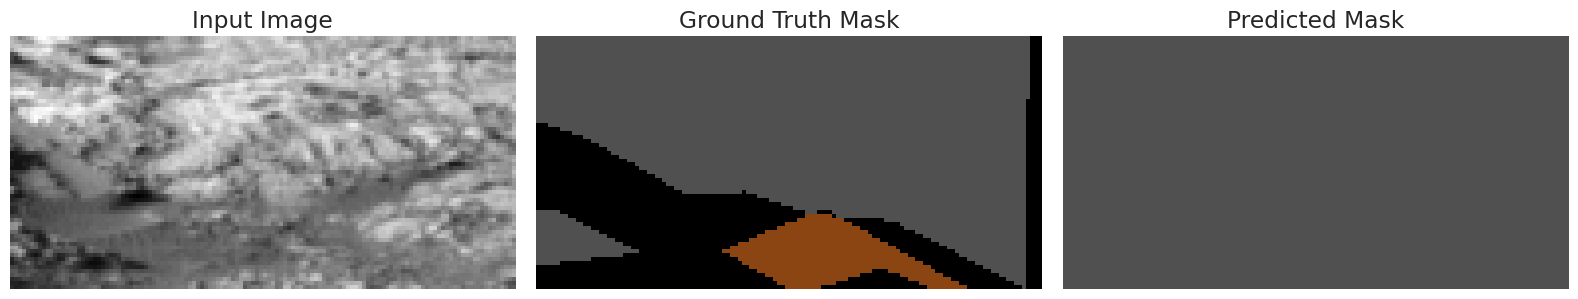

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 634ms/step - accuracy: 0.7372 - loss: 0.0192 - mean_iou: 0.9591 - val_accuracy: 0.6928 - val_loss: 0.2233 - val_mean_iou: 0.6933 - learning_rate: 1.0000e-04
Epoch 92/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.7364 - loss: 0.0232 - mean_iou: 0.9638 - val_accuracy: 0.6917 - val_loss: 0.2183 - val_mean_iou: 0.6964 - learning_rate: 1.0000e-04
Epoch 93/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7350 - loss: 0.0236 - mean_iou: 0.9533 - val_accuracy: 0.6906 - val_loss: 0.2252 - val_mean_iou: 0.6944 - learning_rate: 1.0000e-04
Epoch 94/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7340 - loss: 0.0223 - mean_iou: 0.9628 - val_accuracy: 0.6920 - val_loss: 0.2192 - val_mean_iou: 0.6950 - learning_rate: 1.0000e-04
Epoch 95/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7362 - loss: 0.0183 - mean_iou: 0.9618 - val_accuracy: 0.6926 - val_loss: 0.2196 - val_mean_iou: 0.6982 - learning_rate: 1.0000e-04
Epoc

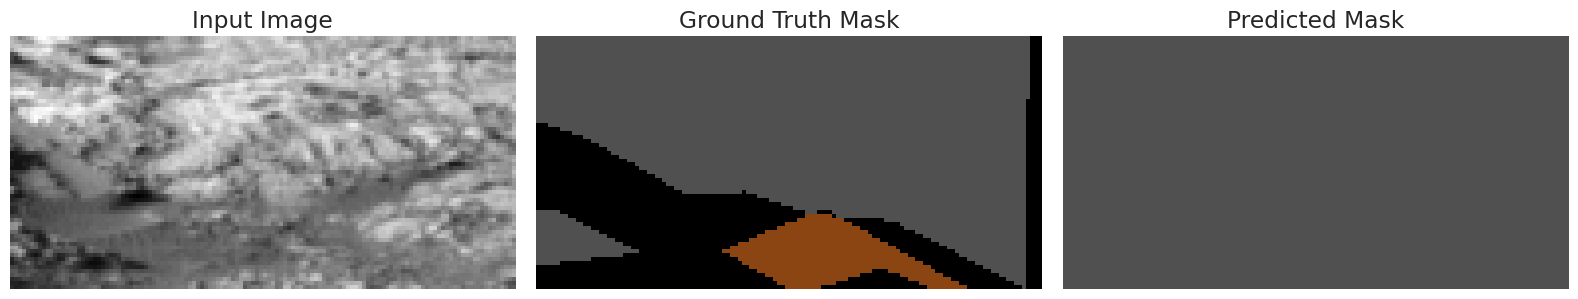

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 634ms/step - accuracy: 0.7375 - loss: 0.0184 - mean_iou: 0.9558 - val_accuracy: 0.6925 - val_loss: 0.2199 - val_mean_iou: 0.6974 - learning_rate: 1.0000e-04
Epoch 97/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.7390 - loss: 0.0181 - mean_iou: 0.9541 - val_accuracy: 0.6922 - val_loss: 0.2219 - val_mean_iou: 0.7000 - learning_rate: 1.0000e-04
Epoch 98/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7399 - loss: 0.0162 - mean_iou: 0.9742 - val_accuracy: 0.6925 - val_loss: 0.2195 - val_mean_iou: 0.6988 - learning_rate: 1.0000e-04
Epoch 99/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7407 - loss: 0.0166 - mean_iou: 0.9716 - val_accuracy: 0.6928 - val_loss: 0.2176 - val_mean_iou: 0.6985 - learning_rate: 1.0000e-04
Epoch 100/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7414 - loss: 0.0168 - mean_iou: 0.9651 - val_accuracy: 0.6929 - val_loss: 0.2225 - val_mean_iou: 0.6979 - learning_rate: 1.0000e-04
Epo

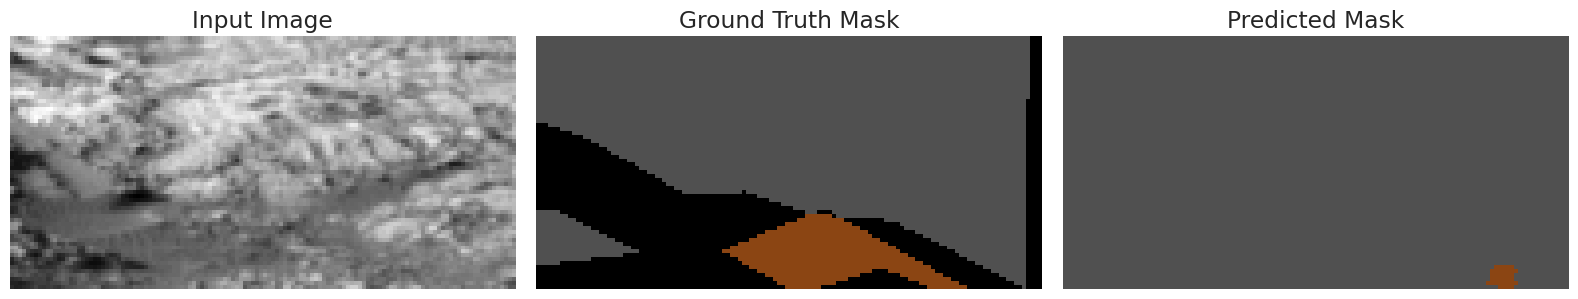

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 663ms/step - accuracy: 0.7401 - loss: 0.0180 - mean_iou: 0.9676 - val_accuracy: 0.6933 - val_loss: 0.2276 - val_mean_iou: 0.7023 - learning_rate: 1.0000e-04
Epoch 102/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - accuracy: 0.7372 - loss: 0.0166 - mean_iou: 0.9715 - val_accuracy: 0.6913 - val_loss: 0.2263 - val_mean_iou: 0.6955 - learning_rate: 1.0000e-04
Epoch 103/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7373 - loss: 0.0164 - mean_iou: 0.9594 - val_accuracy: 0.6944 - val_loss: 0.2319 - val_mean_iou: 0.7076 - learning_rate: 1.0000e-04
Epoch 104/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.7420 - loss: 0.0166 - mean_iou: 0.9687 - val_accuracy: 0.6916 - val_loss: 0.2195 - val_mean_iou: 0.7028 - learning_rate: 1.0000e-04
Epoch 105/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.7435 - loss: 0.0155 - mean_iou: 0.9750 - val_accuracy: 0.6930 - val_loss: 0.2345 - val_mean_iou: 0.6979 - learning_rate: 1.0000e-04


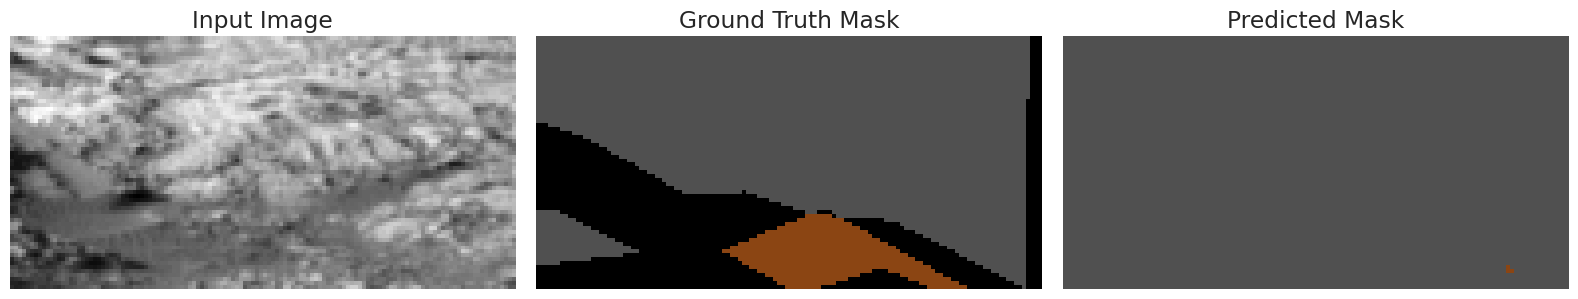

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.7388 - loss: 0.0164 - mean_iou: 0.9726 - val_accuracy: 0.6927 - val_loss: 0.2432 - val_mean_iou: 0.6950 - learning_rate: 1.0000e-04
Epoch 107/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.7392 - loss: 0.0166 - mean_iou: 0.9622 - val_accuracy: 0.6939 - val_loss: 0.2384 - val_mean_iou: 0.6970 - learning_rate: 1.0000e-04
Epoch 108/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.7402 - loss: 0.0157 - mean_iou: 0.9664 - val_accuracy: 0.6934 - val_loss: 0.2321 - val_mean_iou: 0.6981 - learning_rate: 1.0000e-04
Epoch 109/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7402 - loss: 0.0159 - mean_iou: 0.9513 - val_accuracy: 0.6925 - val_loss: 0.2345 - val_mean_iou: 0.6979 - learning_rate: 1.0000e-04
Epoch 110/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7401 - loss: 0.0163 - mean_iou: 0.9666 - val_accuracy: 0.6902 - val_loss: 0.2320 - val_mean_iou: 0.6929 - learning_rate: 1.0000e-04


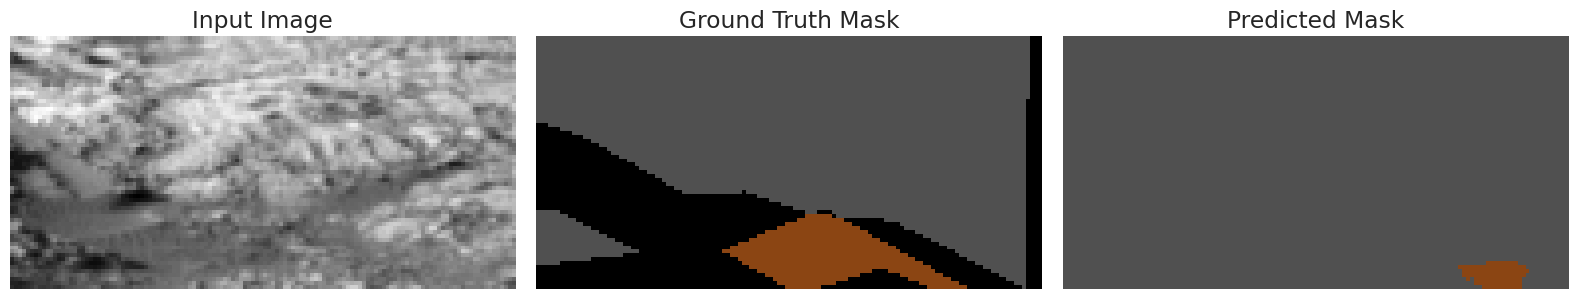

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 634ms/step - accuracy: 0.7407 - loss: 0.0154 - mean_iou: 0.9764 - val_accuracy: 0.6899 - val_loss: 0.2439 - val_mean_iou: 0.6939 - learning_rate: 1.0000e-04
Epoch 112/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7398 - loss: 0.0145 - mean_iou: 0.9684 - val_accuracy: 0.6922 - val_loss: 0.2415 - val_mean_iou: 0.6982 - learning_rate: 1.0000e-04
Epoch 113/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7391 - loss: 0.0161 - mean_iou: 0.9733 - val_accuracy: 0.6924 - val_loss: 0.2313 - val_mean_iou: 0.7013 - learning_rate: 1.0000e-04
Epoch 114/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7403 - loss: 0.0140 - mean_iou: 0.9618 - val_accuracy: 0.6927 - val_loss: 0.2408 - val_mean_iou: 0.7018 - learning_rate: 1.0000e-04
Epoch 115/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.7397 - loss: 0.0125 - mean_iou: 0.9701 - val_accuracy: 0.6921 - val_loss: 0.2389 - val_mean_iou: 0.7003 - learning_rate: 1.0000e-04


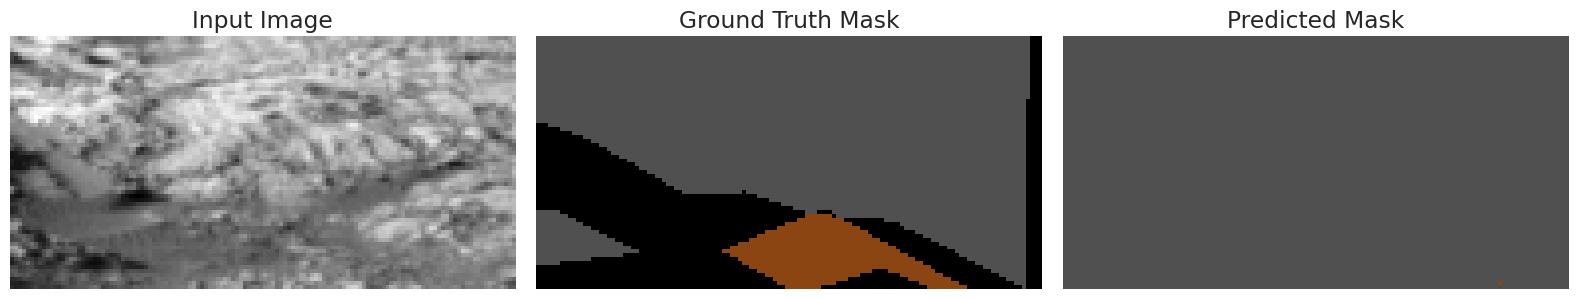

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.7380 - loss: 0.0138 - mean_iou: 0.9786 - val_accuracy: 0.6925 - val_loss: 0.2388 - val_mean_iou: 0.7028 - learning_rate: 1.0000e-04
Epoch 117/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7376 - loss: 0.0134 - mean_iou: 0.9771 - val_accuracy: 0.6927 - val_loss: 0.2389 - val_mean_iou: 0.7036 - learning_rate: 1.0000e-05
Epoch 118/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7411 - loss: 0.0133 - mean_iou: 0.9703 - val_accuracy: 0.6929 - val_loss: 0.2392 - val_mean_iou: 0.7038 - learning_rate: 1.0000e-05
Epoch 119/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7360 - loss: 0.0141 - mean_iou: 0.9708 - val_accuracy: 0.6929 - val_loss: 0.2393 - val_mean_iou: 0.7037 - learning_rate: 1.0000e-05
Epoch 120/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7380 - loss: 0.0129 - mean_iou: 0.9695 - val_accuracy: 0.6920 - val_loss: 0.2376 - val_mean_iou: 0.7036 - learning_rate: 1.0000e-05


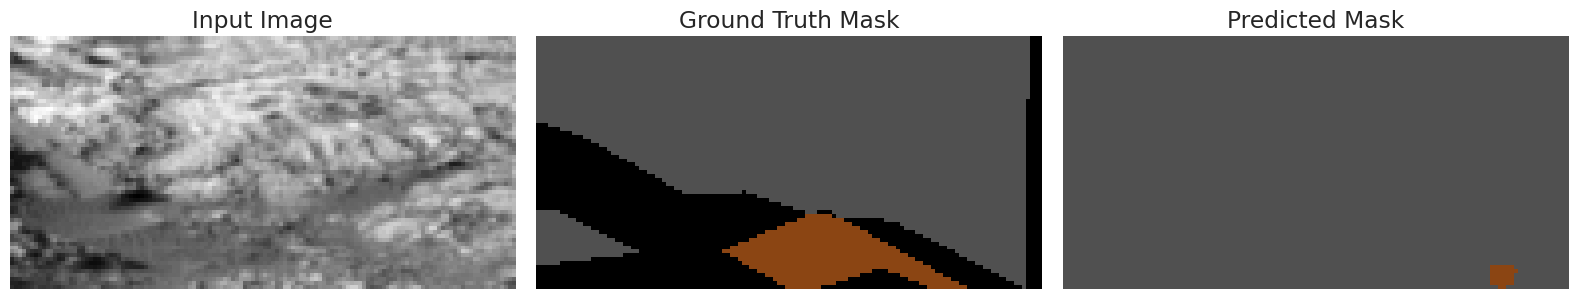

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.7404 - loss: 0.0128 - mean_iou: 0.9784 - val_accuracy: 0.6922 - val_loss: 0.2385 - val_mean_iou: 0.7035 - learning_rate: 1.0000e-05
Epoch 122/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7406 - loss: 0.0121 - mean_iou: 0.9779 - val_accuracy: 0.6922 - val_loss: 0.2397 - val_mean_iou: 0.7032 - learning_rate: 1.0000e-05
Epoch 123/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.7452 - loss: 0.0131 - mean_iou: 0.9708 - val_accuracy: 0.6921 - val_loss: 0.2398 - val_mean_iou: 0.7026 - learning_rate: 1.0000e-05
Epoch 124/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.7406 - loss: 0.0133 - mean_iou: 0.9785 - val_accuracy: 0.6923 - val_loss: 0.2415 - val_mean_iou: 0.7026 - learning_rate: 1.0000e-05
Epoch 125/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.7397 - loss: 0.0131 - mean_iou: 0.9703 - val_accuracy: 0.6925 - val_loss: 0.2516 - val_mean_iou: 0.7059 - learning_rate: 1.0000e-05


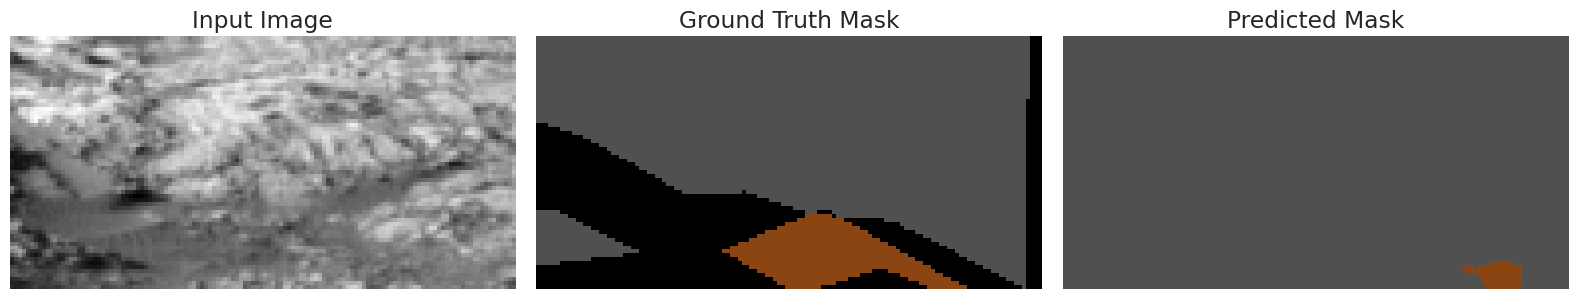

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 638ms/step - accuracy: 0.7441 - loss: 0.0130 - mean_iou: 0.9705 - val_accuracy: 0.6927 - val_loss: 0.2474 - val_mean_iou: 0.7041 - learning_rate: 1.0000e-05
Epoch 127/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7429 - loss: 0.0128 - mean_iou: 0.9721 - val_accuracy: 0.6926 - val_loss: 0.2429 - val_mean_iou: 0.7024 - learning_rate: 1.0000e-05
Epoch 128/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7423 - loss: 0.0132 - mean_iou: 0.9685 - val_accuracy: 0.6924 - val_loss: 0.2396 - val_mean_iou: 0.7019 - learning_rate: 1.0000e-05
Epoch 129/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7419 - loss: 0.0125 - mean_iou: 0.9701 - val_accuracy: 0.6922 - val_loss: 0.2396 - val_mean_iou: 0.7005 - learning_rate: 1.0000e-05
Epoch 130/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7362 - loss: 0.0143 - mean_iou: 0.9683 - val_accuracy: 0.6917 - val_loss: 0.2409 - val_mean_iou: 0.6994 - learning_rate: 1.0000e-05


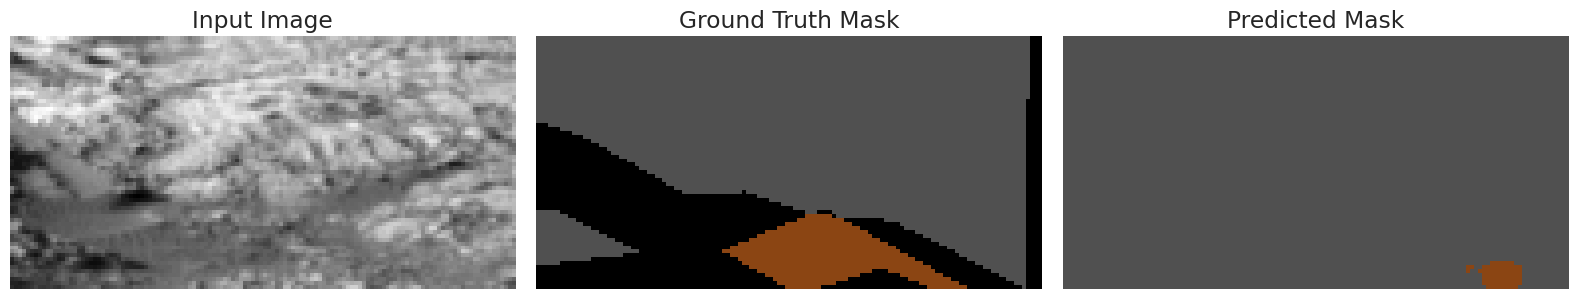

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 637ms/step - accuracy: 0.7371 - loss: 0.0121 - mean_iou: 0.9781 - val_accuracy: 0.6918 - val_loss: 0.2419 - val_mean_iou: 0.6997 - learning_rate: 1.0000e-05
Epoch 132/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7398 - loss: 0.0117 - mean_iou: 0.9800 - val_accuracy: 0.6917 - val_loss: 0.2431 - val_mean_iou: 0.6990 - learning_rate: 1.0000e-05
Epoch 133/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7384 - loss: 0.0125 - mean_iou: 0.9687 - val_accuracy: 0.6917 - val_loss: 0.2428 - val_mean_iou: 0.6987 - learning_rate: 1.0000e-05
Epoch 134/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.7375 - loss: 0.0128 - mean_iou: 0.9710 - val_accuracy: 0.6919 - val_loss: 0.2411 - val_mean_iou: 0.6985 - learning_rate: 1.0000e-05
Epoch 135/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7417 - loss: 0.0114 - mean_iou: 0.9733 - val_accuracy: 0.6920 - val_loss: 0.2416 - val_mean_iou: 0.6992 - learning_rate: 1.0000e-05


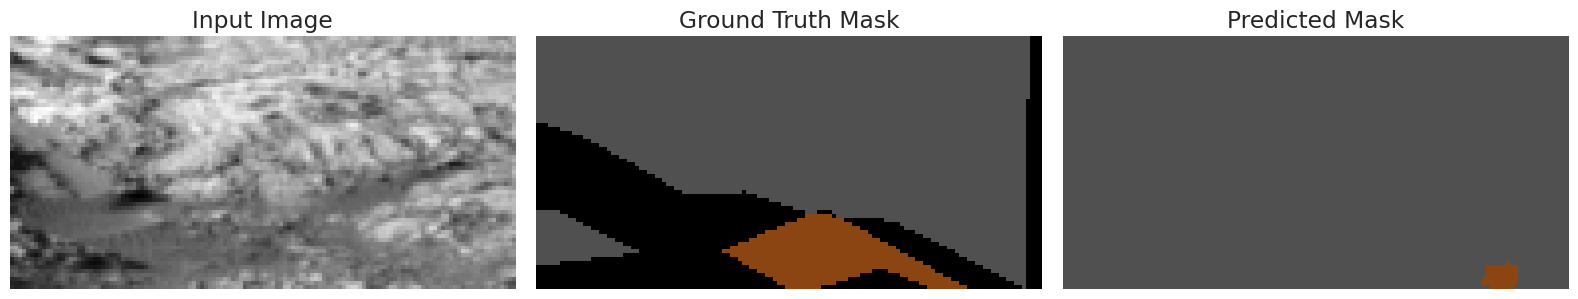

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 634ms/step - accuracy: 0.7366 - loss: 0.0120 - mean_iou: 0.9701 - val_accuracy: 0.6922 - val_loss: 0.2416 - val_mean_iou: 0.7000 - learning_rate: 1.0000e-05
Epoch 137/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7383 - loss: 0.0118 - mean_iou: 0.9818 - val_accuracy: 0.6925 - val_loss: 0.2411 - val_mean_iou: 0.7003 - learning_rate: 1.0000e-05
Epoch 138/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7396 - loss: 0.0128 - mean_iou: 0.9614 - val_accuracy: 0.6925 - val_loss: 0.2424 - val_mean_iou: 0.7007 - learning_rate: 1.0000e-05
Epoch 139/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7436 - loss: 0.0111 - mean_iou: 0.9787 - val_accuracy: 0.6924 - val_loss: 0.2449 - val_mean_iou: 0.7005 - learning_rate: 1.0000e-05
Epoch 140/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.7402 - loss: 0.0124 - mean_iou: 0.9721 - val_accuracy: 0.6925 - val_loss: 0.2435 - val_mean_iou: 0.7009 - learning_rate: 1.0000e-05


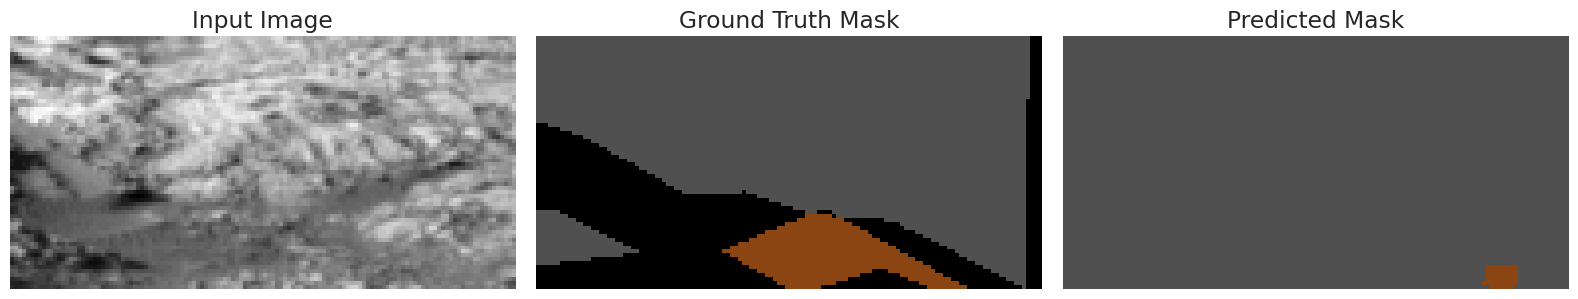

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 633ms/step - accuracy: 0.7375 - loss: 0.0135 - mean_iou: 0.9593 - val_accuracy: 0.6924 - val_loss: 0.2417 - val_mean_iou: 0.6995 - learning_rate: 1.0000e-05
Epoch 142/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.7425 - loss: 0.0127 - mean_iou: 0.9761 - val_accuracy: 0.6925 - val_loss: 0.2435 - val_mean_iou: 0.6990 - learning_rate: 1.0000e-05
Epoch 143/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7399 - loss: 0.0135 - mean_iou: 0.9696 - val_accuracy: 0.6926 - val_loss: 0.2443 - val_mean_iou: 0.6999 - learning_rate: 1.0000e-05
Epoch 144/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.7388 - loss: 0.0118 - mean_iou: 0.9800 - val_accuracy: 0.6922 - val_loss: 0.2453 - val_mean_iou: 0.7005 - learning_rate: 1.0000e-05
Epoch 145/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.7420 - loss: 0.0123 - mean_iou: 0.9637 - val_accuracy: 0.6922 - val_loss: 0.2455 - val_mean_iou: 0.7005 - learning_rate: 1.0000e-05


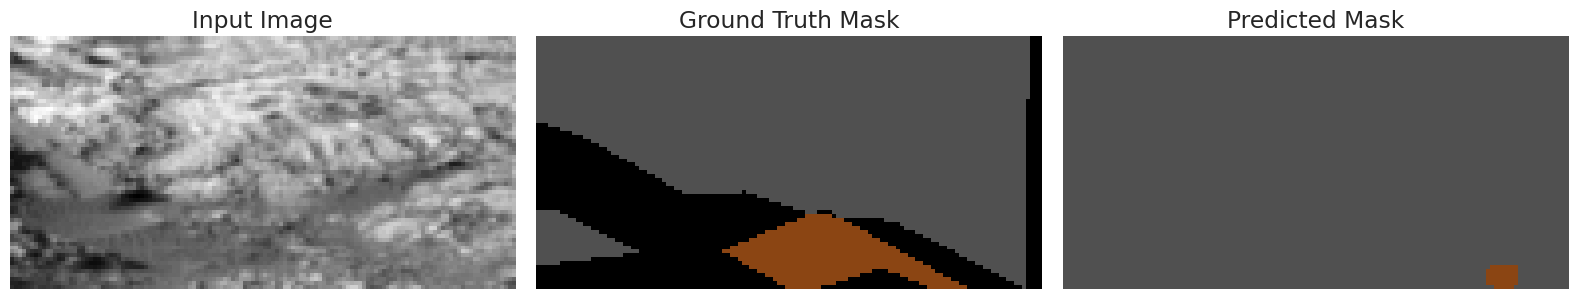

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 632ms/step - accuracy: 0.7404 - loss: 0.0126 - mean_iou: 0.9720 - val_accuracy: 0.6926 - val_loss: 0.2444 - val_mean_iou: 0.7011 - learning_rate: 1.0000e-05
Epoch 147/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.7414 - loss: 0.0129 - mean_iou: 0.9712 - val_accuracy: 0.6925 - val_loss: 0.2457 - val_mean_iou: 0.6996 - learning_rate: 1.0000e-05
Epoch 148/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7411 - loss: 0.0128 - mean_iou: 0.9696 - val_accuracy: 0.6926 - val_loss: 0.2438 - val_mean_iou: 0.6996 - learning_rate: 1.0000e-05
Epoch 149/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7389 - loss: 0.0121 - mean_iou: 0.9781 - val_accuracy: 0.6921 - val_loss: 0.2464 - val_mean_iou: 0.7003 - learning_rate: 1.0000e-05
Epoch 150/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7396 - loss: 0.0128 - mean_iou: 0.9700 - val_accuracy: 0.6919 - val_loss: 0.2459 - val_mean_iou: 0.6995 - learning_rate: 1.0000e-05


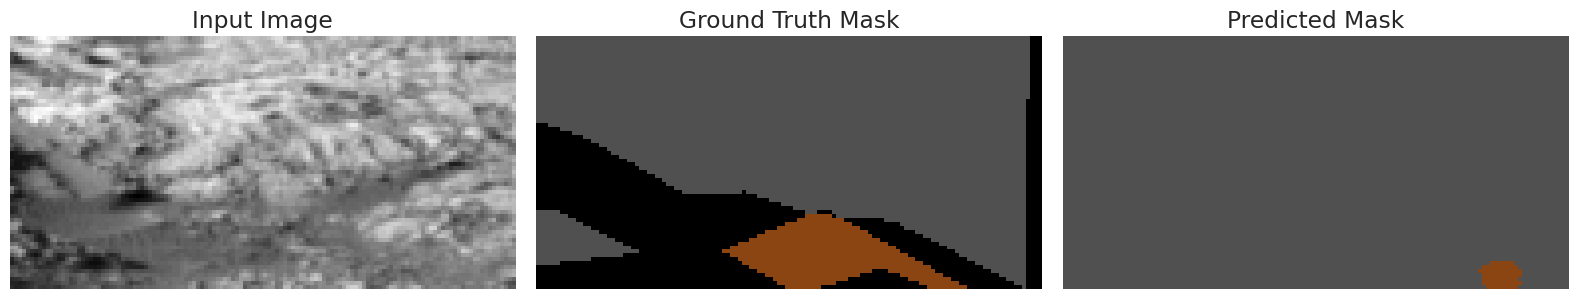

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - accuracy: 0.7392 - loss: 0.0126 - mean_iou: 0.9768 - val_accuracy: 0.6920 - val_loss: 0.2480 - val_mean_iou: 0.6988 - learning_rate: 1.0000e-05
Epoch 152/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.7390 - loss: 0.0112 - mean_iou: 0.9717 - val_accuracy: 0.6920 - val_loss: 0.2479 - val_mean_iou: 0.6992 - learning_rate: 1.0000e-05
Epoch 153/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7401 - loss: 0.0126 - mean_iou: 0.9679 - val_accuracy: 0.6922 - val_loss: 0.2466 - val_mean_iou: 0.6993 - learning_rate: 1.0000e-05
Final validation Mean Intersection Over Union: 70.76%


In [124]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, learning_rate, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

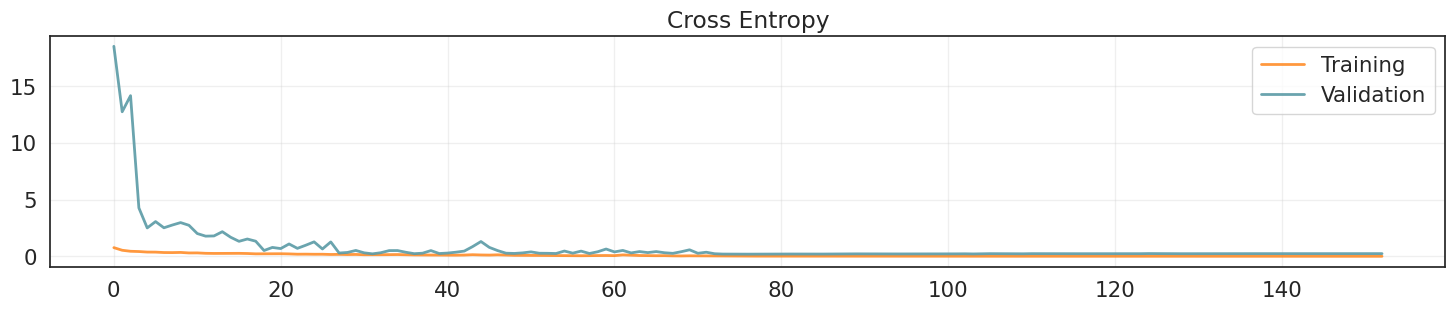

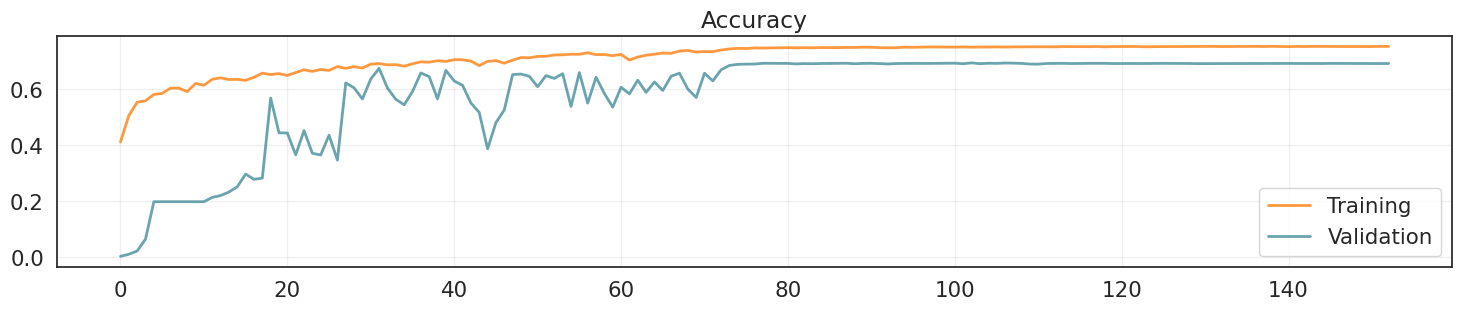

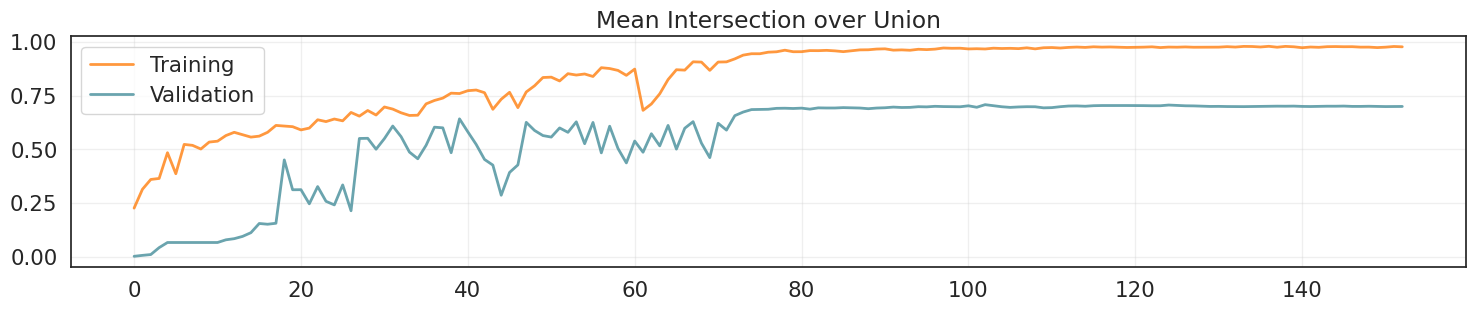

In [125]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🔮 Predictions on the Test Set

In [126]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [128]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step
Predictions shape: (10022, 64, 128)


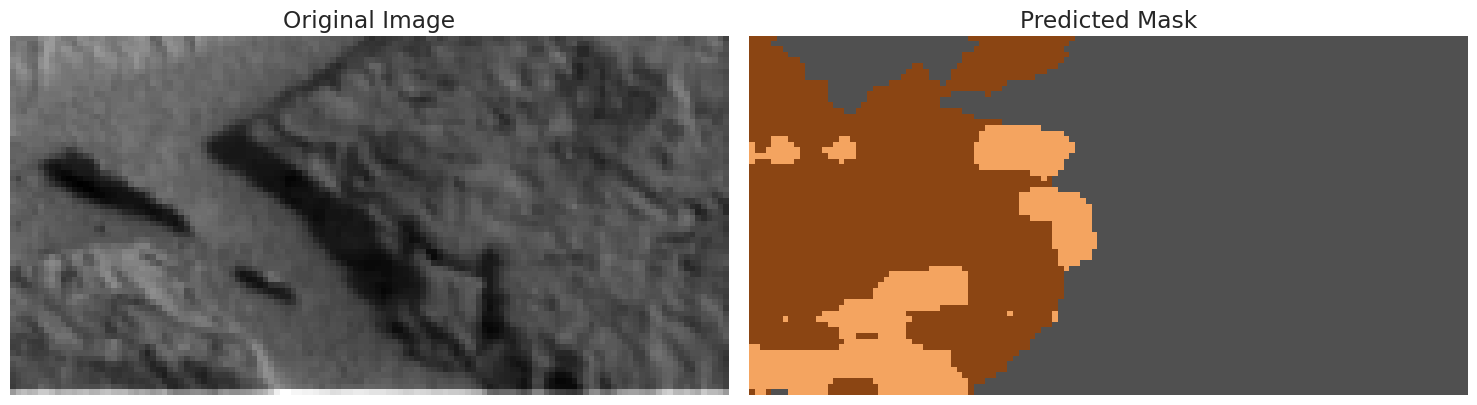

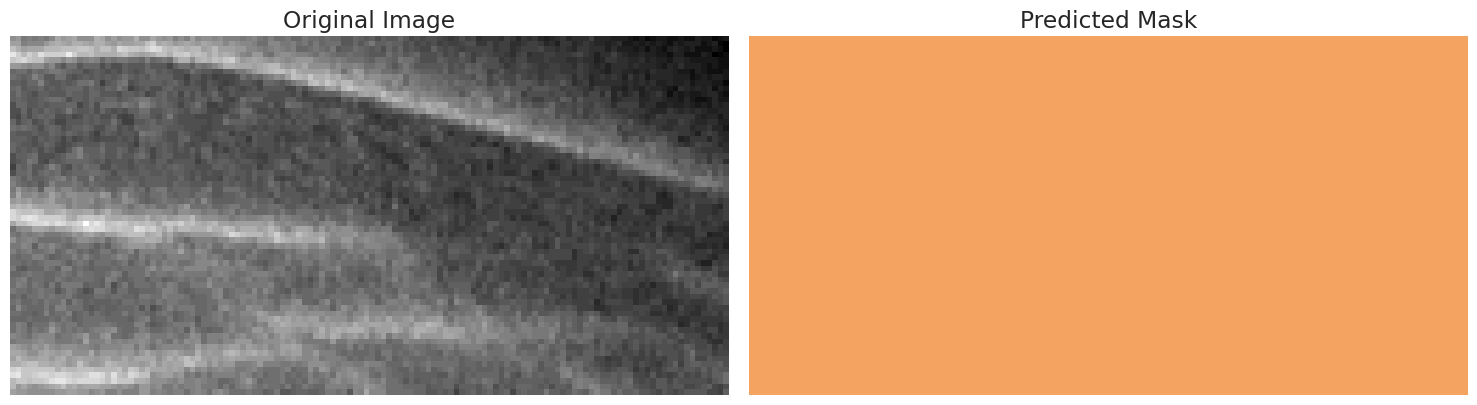

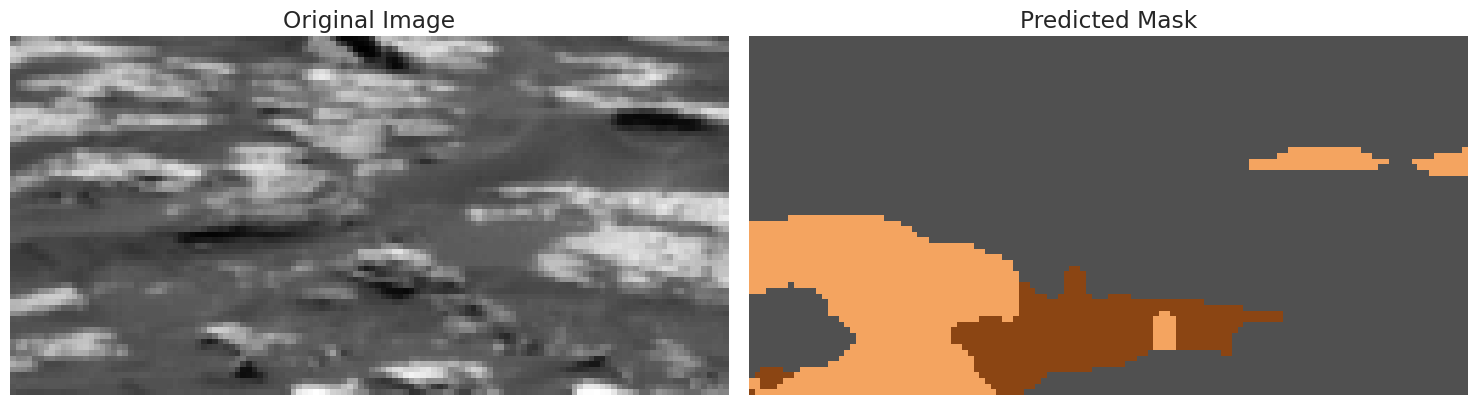

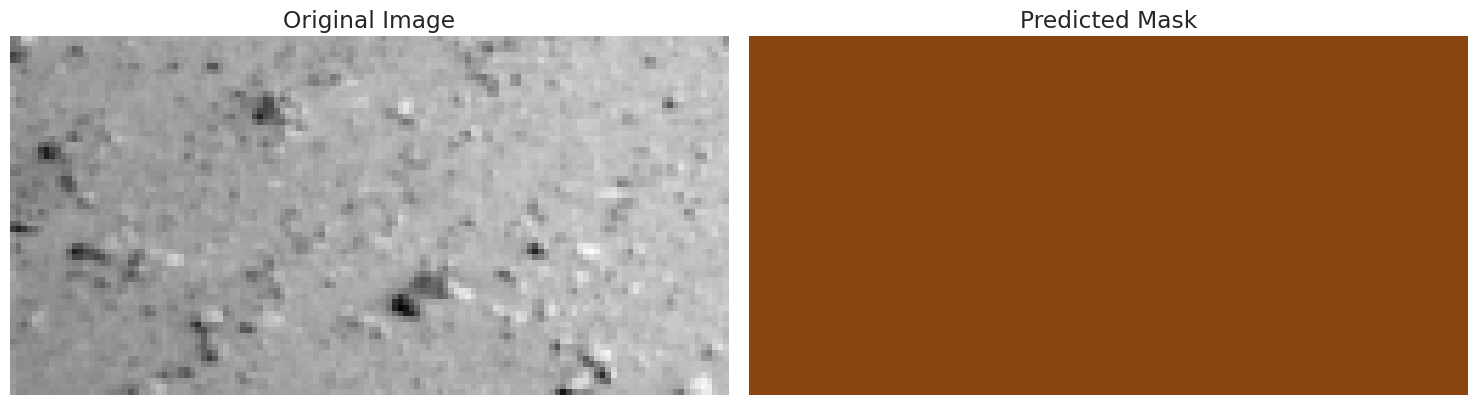

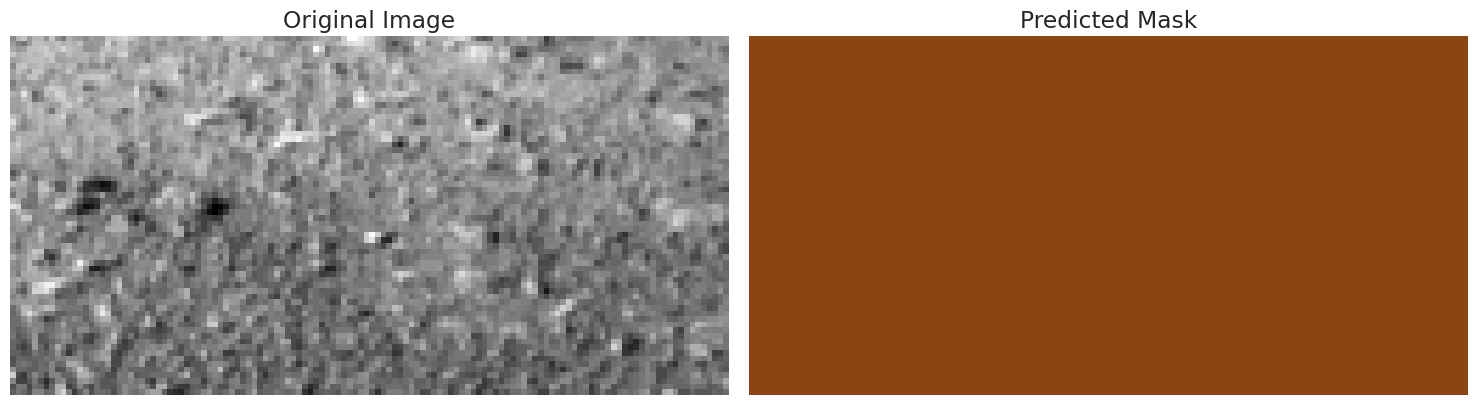

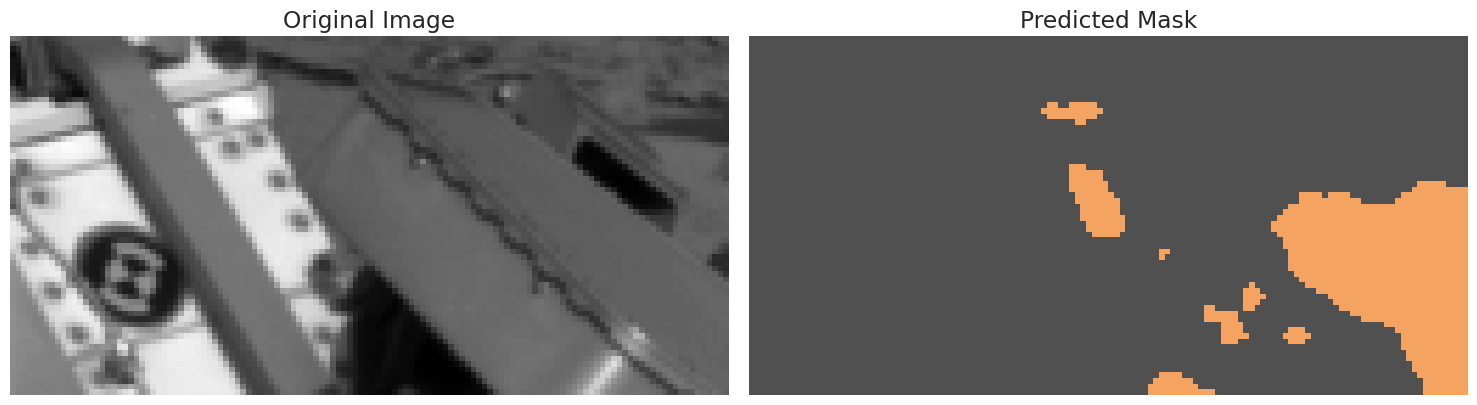

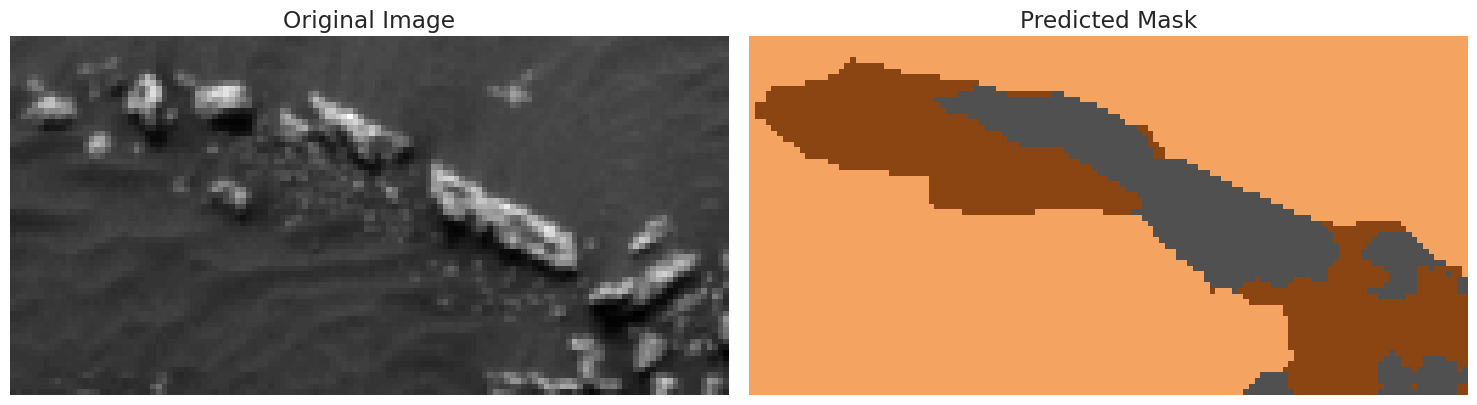

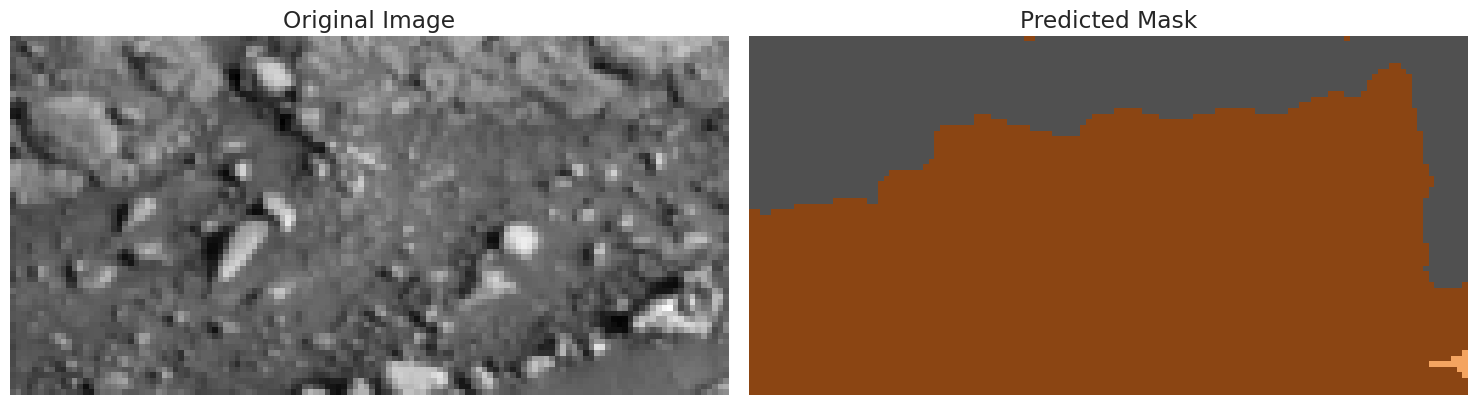

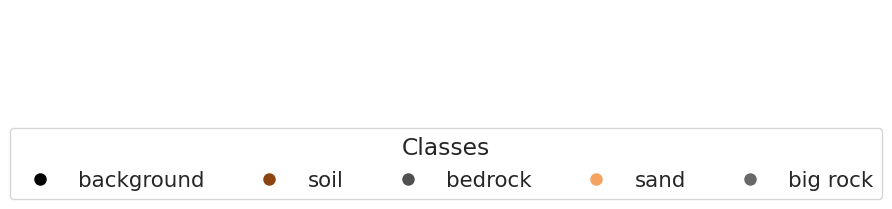

In [129]:
# Plot some predictions 
num_samples = 8
# Only take the first `num_samples` from X_test and preds
images = X_test[:num_samples]
predictions = preds[:num_samples]

# Adjust the number of classes to match the actual classes in the predictions 
num_classes = len(classes) 

# Create a list to store the handles for the legend 
handles = []

for i in range(num_samples):
    # Get the i-th image and its prediction
    image = images[i]
    predicted_mask = predictions[i]

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot original image
    axes[0].set_title("Original Image")
    axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].set_title("Predicted Mask")
    colored_pred = apply_colormap(predicted_mask, colormap)
    axes[1].imshow(colored_pred)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Legend
for label_idx in category_map: 
    color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))

# Create a single legend displayed at the bottom
fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
ax.axis('off')
plt.show()

In [130]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [131]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

In [132]:
# Delete the model to free up resources
del model